## Comparing KGs to real-world complex networks

Using all instant KGs from the KGen-generated *ISWC* 2021 KG constituents as target

# Environment Setup

Install & imports

In [1]:
# Install required packages
import sys
!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

# Imports
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.5 MB/s eta 0:00:00


Auxiliary functions

In [2]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))

    Ref.: https://stackoverflow.com/a/62662992
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

rdfs = {'0': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/00/abs_preprocessed_kg.ttl',
        '1': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/01/abs_preprocessed_kg.ttl',
        '2': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/02/abs_preprocessed_kg.ttl',
        '3': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/03/abs_preprocessed_kg.ttl',
        '4': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/04/abs_preprocessed_kg.ttl',
        '5': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/05/abs_preprocessed_kg.ttl',
        '6': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/06/abs_preprocessed_kg.ttl',
        '7': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/07/abs_preprocessed_kg.ttl',
        '8': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/08/abs_preprocessed_kg.ttl',
        '9': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/09/abs_preprocessed_kg.ttl',
        '10': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/10/abs_preprocessed_kg.ttl',
        '11': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/11/abs_preprocessed_kg.ttl',
        '12': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/12/abs_preprocessed_kg.ttl',
        '13': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/13/abs_preprocessed_kg.ttl',
        '14': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/14/abs_preprocessed_kg.ttl',
        '15': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/15/abs_preprocessed_kg.ttl',
        '16': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/16/abs_preprocessed_kg.ttl',
        '17': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/17/abs_preprocessed_kg.ttl',
        '18': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/18/abs_preprocessed_kg.ttl',
        '19': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/19/abs_preprocessed_kg.ttl',
        '20': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/20/abs_preprocessed_kg.ttl',
        '21': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/21/abs_preprocessed_kg.ttl',
        '22': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/22/abs_preprocessed_kg.ttl',
        '23': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/23/abs_preprocessed_kg.ttl'}

## Loading RDF model

Pointing to a remote Turtle (*.ttl) file.

In [3]:
rgs = dict()
for i in rdfs.keys():
    rg = RDFGraph()
    rg.parse(rdfs[i], format='ttl') # Turtle format

    print("rdflib Graph {} loaded successfully with {} triples".format(i, len(rg)))
    rgs[i] = rg

rdflib Graph 0 loaded successfully with 571 triples
rdflib Graph 1 loaded successfully with 686 triples
rdflib Graph 2 loaded successfully with 773 triples
rdflib Graph 3 loaded successfully with 816 triples
rdflib Graph 4 loaded successfully with 650 triples
rdflib Graph 5 loaded successfully with 707 triples
rdflib Graph 6 loaded successfully with 1381 triples
rdflib Graph 7 loaded successfully with 555 triples
rdflib Graph 8 loaded successfully with 915 triples
rdflib Graph 9 loaded successfully with 746 triples
rdflib Graph 10 loaded successfully with 658 triples
rdflib Graph 11 loaded successfully with 485 triples
rdflib Graph 12 loaded successfully with 298 triples
rdflib Graph 13 loaded successfully with 785 triples
rdflib Graph 14 loaded successfully with 443 triples
rdflib Graph 15 loaded successfully with 553 triples
rdflib Graph 16 loaded successfully with 426 triples
rdflib Graph 17 loaded successfully with 882 triples
rdflib Graph 18 loaded successfully with 593 triples
rd

## Converting rdflib.Graph to networkx.MultiDiGraph

KGs are directed graphs with the possibility of multiple paralell edges.

In [4]:
TKG = dict()
for i in rgs:
    # Conversion of rdflib.Graph to networkx.MultiDiGraph
    KG = rdflib_to_networkx_multidigraph(rgs[i])
    print("networkx Graph loaded successfully with length {}".format(len(KG)))

    TKG[i] = KG

networkx Graph loaded successfully with length 326
networkx Graph loaded successfully with length 402
networkx Graph loaded successfully with length 425
networkx Graph loaded successfully with length 466
networkx Graph loaded successfully with length 371
networkx Graph loaded successfully with length 402
networkx Graph loaded successfully with length 718
networkx Graph loaded successfully with length 310
networkx Graph loaded successfully with length 494
networkx Graph loaded successfully with length 436
networkx Graph loaded successfully with length 371
networkx Graph loaded successfully with length 285
networkx Graph loaded successfully with length 177
networkx Graph loaded successfully with length 432
networkx Graph loaded successfully with length 255
networkx Graph loaded successfully with length 316
networkx Graph loaded successfully with length 263
networkx Graph loaded successfully with length 467
networkx Graph loaded successfully with length 351
networkx Graph loaded successfu

# General Network Metrics

Network size and density

In [5]:
for i in TKG:
    # Network size
    print(f"NETWORK {i} SIZE")
    print("============")
    print("The network has {} nodes and {} edges".format(TKG[i].number_of_nodes(), TKG[i].number_of_edges()))
    print()

    # Density
    print(f"NETWORK {i} DENSITY")
    print("============")
    print("The network density is {}".format(nx.density(TKG[i])))
    print()

NETWORK 0 SIZE
The network has 326 nodes and 571 edges

NETWORK 0 DENSITY
The network density is 0.00538933459178858

NETWORK 1 SIZE
The network has 402 nodes and 686 edges

NETWORK 1 DENSITY
The network density is 0.004255530328407836

NETWORK 2 SIZE
The network has 425 nodes and 773 edges

NETWORK 2 DENSITY
The network density is 0.004289678135405105

NETWORK 3 SIZE
The network has 466 nodes and 816 edges

NETWORK 3 DENSITY
The network density is 0.003765748304028797

NETWORK 4 SIZE
The network has 371 nodes and 650 edges

NETWORK 4 DENSITY
The network density is 0.004735193414438697

NETWORK 5 SIZE
The network has 402 nodes and 707 edges

NETWORK 5 DENSITY
The network density is 0.004385801664991749

NETWORK 6 SIZE
The network has 718 nodes and 1381 edges

NETWORK 6 DENSITY
The network density is 0.0026825639172814615

NETWORK 7 SIZE
The network has 310 nodes and 555 edges

NETWORK 7 DENSITY
The network density is 0.0057939242092076414

NETWORK 8 SIZE
The network has 494 nodes and 9

# Scale-free Networks

In-degree distribution -- Is it Poisson's or Power-law alike?

Text(0, 0.5, 'Frequency')

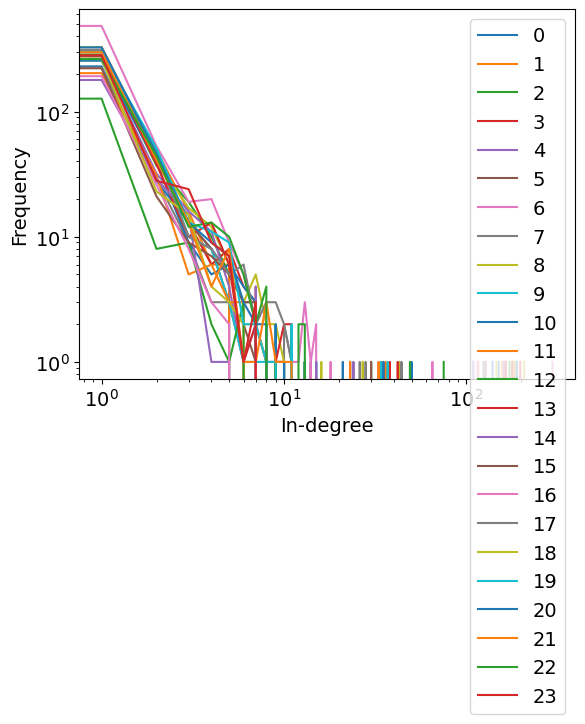

In [6]:
styles = {'2019': 'ro-',
          '2020': 'gx-.',
          '2021': 'b*--'}
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))

for i in TKG:
    degree_freq = degree_histogram_directed(TKG[i], in_degree=True)
    degrees = range(len(degree_freq))
    plt.loglog(degrees, degree_freq, label=i)
plt.legend(loc="upper right")
plt.xlabel('In-degree')
plt.ylabel('Frequency')

Out-degree distribution

Text(0, 0.5, 'Frequency')

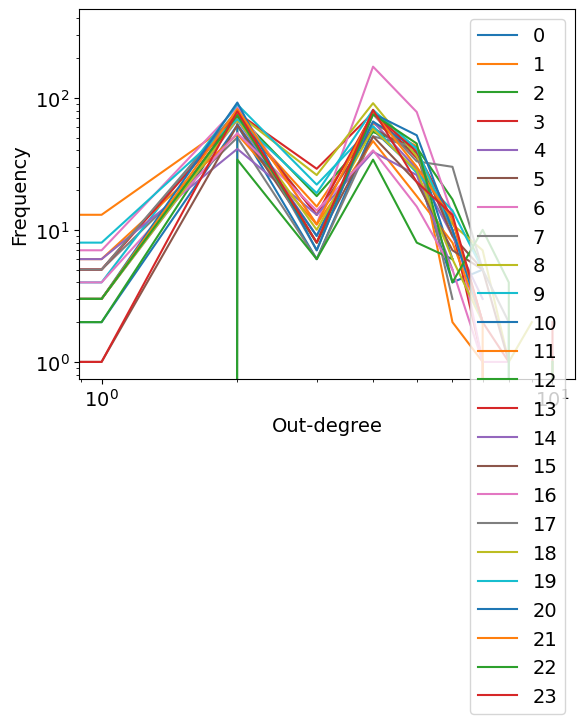

In [7]:
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))

for i in TKG:
    degree_freq = degree_histogram_directed(TKG[i], out_degree=True)
    degrees = range(len(degree_freq))
    plt.loglog(degrees, degree_freq, label=i)
plt.legend(loc="upper right")
plt.xlabel('Out-degree')
plt.ylabel('Frequency')

Are there HUBS available?

In [8]:
for i in ['19']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network 19 Hubs:
[(rdflib.term.URIRef('http://local/local.owl#need_to_address_page_from_61_percent_of_internet_host_markup_do_not_actually_describe_datasets'), 0.006035764177685946), (rdflib.term.URIRef('http://local/local.owl#need_to_address_page_from_61_percent_of_internet_host_markup'), 0.005948485335305754), (rdflib.term.URIRef('http://local/local.owl#vertical_search_engine_for_datasets_on_google_dataset_search'), 0.005899623493725796), (rdflib.term.URIRef('http://local/local.owl#page_61_percent_of_internet_host_markup'), 0.005859489207077343), (rdflib.term.URIRef('http://local/local.owl#page_schemaorgdataset_markup'), 0.005794970134417958), (rdflib.term.URIRef('http://local/local.owl#page_where_this_markup_be_not_reliable'), 0.005765001655600505), (rdflib.term.URIRef('http://local/local.owl#broad_range_of_application_from_vertical_search_engine_to_rich_snippet_in_search_result_to_action_on_email_to_many_others'), 0.00571715352308818), (rdflib.term.URIRef('http://local/local.owl#ve

In [9]:
for i in ['20']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network 20 Hubs:
[(rdflib.term.URIRef('http://local/local.owl#crossentropy_loss_between_a_prediction_the_neural_network_visual_embed_space'), 0.006266069466985428), (rdflib.term.URIRef('http://local/local.owl#minimize_the_crossentropy_loss_between_a_prediction_the_neural_network_visual_embed_space'), 0.006266069466985428), (rdflib.term.URIRef('http://local/local.owl#minimize_the_crossentropy_loss_between_a_give_class_label_the_neural_network_visual_embed_space'), 0.006235366058294815), (rdflib.term.URIRef('http://local/local.owl#crossentropy_loss_between_a_give_class_label_the_neural_network_visual_embed_space'), 0.006235366058294815), (rdflib.term.URIRef('http://local/local.owl#minimize_the_crossentropy_loss_between_a_prediction_the_neural_network'), 0.00608203327374787), (rdflib.term.URIRef('http://local/local.owl#minimize_the_crossentropy_loss_between_a_give_class_label_the_neural_network'), 0.006051329865057256), (rdflib.term.URIRef('http://local/local.owl#neural_network_domain'), 

In [10]:
for i in ['21']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network 21 Hubs:
[(rdflib.term.URIRef('http://local/local.owl#extend_conjunctive_query_in_the_policy_with_comparison_predicate_and_introduce_preference_between_ontology_predicate_thus_in_principle_augment_the_throughput_of_query_answer'), 0.00633583845255351), (rdflib.term.URIRef('http://local/local.owl#limit_form_of_policy_typically_constitute_by_conjunctive_query_whose_answer_must_never_be_infer_by_a_user'), 0.006149479917075938), (rdflib.term.URIRef('http://local/local.owl#conjunctive_query_whose_answer_must_never_be_infer_by_a_user'), 0.005838523780277662), (rdflib.term.URIRef('http://local/local.owl#ontology_predicate_thus_in_principle_augment_the_throughput_of_query_answer'), 0.005764630401483015), (rdflib.term.URIRef('http://local/local.owl#answer_conjunctive_query'), 0.005730630389097694), (rdflib.term.URIRef('http://local/local.owl#policy_complexity'), 0.0057227317878476396), (rdflib.term.URIRef('http://local/local.owl#experiment_on_a_popular_benchmark_show_effectiveness_of_we

# Communities

Check for communities using the Clauset-Newman-Moore Algorithm (greedy modularity - applicable to directed graphs)

In [11]:
for k in TKG:
    comms = nx.community.greedy_modularity_communities(TKG[k])

    print(f'Network {k} -- Found {len(comms)} communities.')
    idx = 0
    for i in comms:
        print(f'Community {idx} has {len(i)} nodes.')
        #print(i)
        idx = idx + 1

Network 0 -- Found 14 communities.
Community 0 has 38 nodes.
Community 1 has 32 nodes.
Community 2 has 30 nodes.
Community 3 has 28 nodes.
Community 4 has 28 nodes.
Community 5 has 25 nodes.
Community 6 has 25 nodes.
Community 7 has 24 nodes.
Community 8 has 20 nodes.
Community 9 has 20 nodes.
Community 10 has 16 nodes.
Community 11 has 15 nodes.
Community 12 has 13 nodes.
Community 13 has 12 nodes.
Network 1 -- Found 15 communities.
Community 0 has 51 nodes.
Community 1 has 47 nodes.
Community 2 has 41 nodes.
Community 3 has 40 nodes.
Community 4 has 39 nodes.
Community 5 has 38 nodes.
Community 6 has 37 nodes.
Community 7 has 21 nodes.
Community 8 has 17 nodes.
Community 9 has 16 nodes.
Community 10 has 15 nodes.
Community 11 has 13 nodes.
Community 12 has 11 nodes.
Community 13 has 8 nodes.
Community 14 has 8 nodes.
Network 2 -- Found 15 communities.
Community 0 has 78 nodes.
Community 1 has 48 nodes.
Community 2 has 47 nodes.
Community 3 has 47 nodes.
Community 4 has 38 nodes.
Comm

# Small-world networks

Does it have a low average shortest path?

In [12]:
for i in TKG:
    if nx.is_strongly_connected(TKG[i]):
        print(f'Network {i} -- Average shortest path length: {nx.average_shortest_path_length(TKG[i])}')
    else:
        print(f'Network {i} is NOT strongly connected!')

Network 0 is NOT strongly connected!
Network 1 is NOT strongly connected!
Network 2 is NOT strongly connected!
Network 3 is NOT strongly connected!
Network 4 is NOT strongly connected!
Network 5 is NOT strongly connected!
Network 6 is NOT strongly connected!
Network 7 is NOT strongly connected!
Network 8 is NOT strongly connected!
Network 9 is NOT strongly connected!
Network 10 is NOT strongly connected!
Network 11 is NOT strongly connected!
Network 12 is NOT strongly connected!
Network 13 is NOT strongly connected!
Network 14 is NOT strongly connected!
Network 15 is NOT strongly connected!
Network 16 is NOT strongly connected!
Network 17 is NOT strongly connected!
Network 18 is NOT strongly connected!
Network 19 is NOT strongly connected!
Network 20 is NOT strongly connected!
Network 21 is NOT strongly connected!
Network 22 is NOT strongly connected!
Network 23 is NOT strongly connected!


Does it have a high clustering coefficient?

In [13]:
for i in TKG:
    # create weighted graph from M, as method is not implemented for MultiDiGraphs
    DG = nx.DiGraph()
    for u,v in TKG[i].edges():
        if DG.has_edge(u,v):
            DG[u][v]['weight'] += 1
        else:
            DG.add_edge(u, v, weight=1)

    ccs = nx.clustering(DG,weight='weight').values()

    print(f"Network {i} -- Clustering coefficient: {sum(ccs)/len(ccs)}")

Network 0 -- Clustering coefficient: 0.030746887312094545
Network 1 -- Clustering coefficient: 0.03943667746807692
Network 2 -- Clustering coefficient: 0.0611962689028013
Network 3 -- Clustering coefficient: 0.0652889822961593
Network 4 -- Clustering coefficient: 0.0638090061585332
Network 5 -- Clustering coefficient: 0.055139848048726924
Network 6 -- Clustering coefficient: 0.03235789261510338
Network 7 -- Clustering coefficient: 0.06314959089933071
Network 8 -- Clustering coefficient: 0.05160193205953091
Network 9 -- Clustering coefficient: 0.03087925172357333
Network 10 -- Clustering coefficient: 0.024534973140514893
Network 11 -- Clustering coefficient: 0.06723262694619123
Network 12 -- Clustering coefficient: 0.025171666273361183
Network 13 -- Clustering coefficient: 0.032827402640989725
Network 14 -- Clustering coefficient: 0.03923638095520767
Network 15 -- Clustering coefficient: 0.04562341099767588
Network 16 -- Clustering coefficient: 0.07248729845222524
Network 17 -- Clusteri

# Some Centrality Measurements

NW 0 DEGREE CENTRALITY
The mean degree centrality is 0.010778669183577118, with stdev 0.024483372002933705
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4276923076923077
The minimum node is we extend this line of research by injecting the strength of summary into snippet, with value 0.003076923076923077
(0.4276923076923077, 0.07076923076923076, 0.052307692307692305, 0.027692307692307693, 0.024615384615384615, 0.021538461538461538, 0.01846153846153846, 0.015384615384615385, 0.012307692307692308, 0.00923076923076923, 0.006153846153846154, 0.003076923076923077) (1, 1, 1, 2, 8, 14, 25, 44, 41, 27, 6, 156)


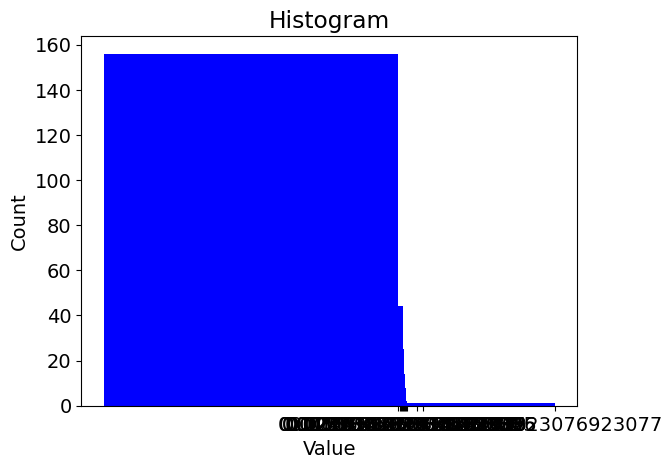


NW 1 DEGREE CENTRALITY
The mean degree centrality is 0.008511060656815627, with stdev 0.02029671264763566
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.3915211970074813
The minimum node is functionality of the w3c recommendation, with value 0.0024937655860349127
(0.3915211970074813, 0.08977556109725686, 0.02493765586034913, 0.022443890274314215, 0.0199501246882793, 0.017456359102244388, 0.014962593516209476, 0.012468827930174564, 0.00997506234413965, 0.007481296758104738, 0.004987531172069825, 0.0024937655860349127) (1, 1, 1, 6, 4, 12, 26, 61, 52, 32, 28, 178)


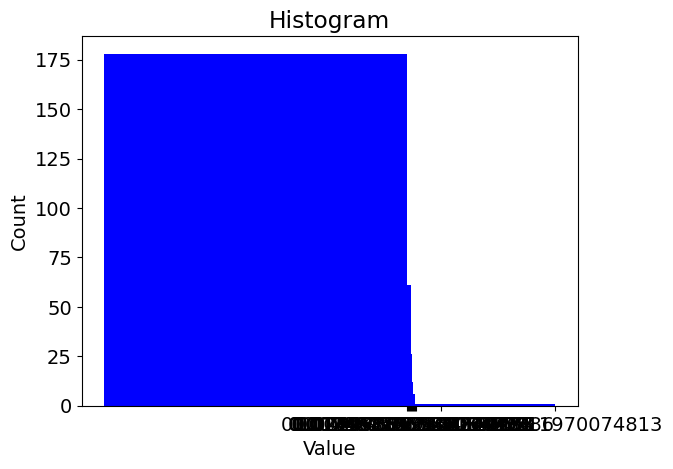


NW 2 DEGREE CENTRALITY
The mean degree centrality is 0.008579356270810192, with stdev 0.021514389622205286
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4292452830188679
The minimum node is set of feature, with value 0.0023584905660377358
(0.4292452830188679, 0.07075471698113207, 0.030660377358490566, 0.02830188679245283, 0.025943396226415092, 0.023584905660377357, 0.02122641509433962, 0.018867924528301886, 0.01650943396226415, 0.014150943396226415, 0.011792452830188678, 0.009433962264150943, 0.007075471698113208, 0.0047169811320754715, 0.0023584905660377358) (1, 1, 2, 1, 2, 2, 5, 14, 14, 41, 45, 52, 34, 7, 204)


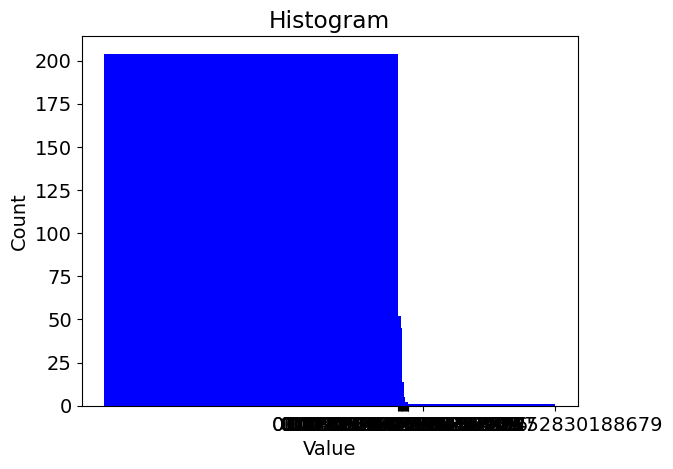


NW 3 DEGREE CENTRALITY
The mean degree centrality is 0.007531496608057521, with stdev 0.020203020222384876
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4236559139784946
The minimum node is knowledge graph, with value 0.002150537634408602
(0.4236559139784946, 0.07311827956989247, 0.025806451612903226, 0.023655913978494623, 0.021505376344086023, 0.01935483870967742, 0.017204301075268817, 0.015053763440860214, 0.012903225806451613, 0.010752688172043012, 0.008602150537634409, 0.0064516129032258064, 0.004301075268817204, 0.002150537634408602) (1, 1, 1, 5, 3, 4, 7, 12, 30, 71, 53, 45, 13, 220)


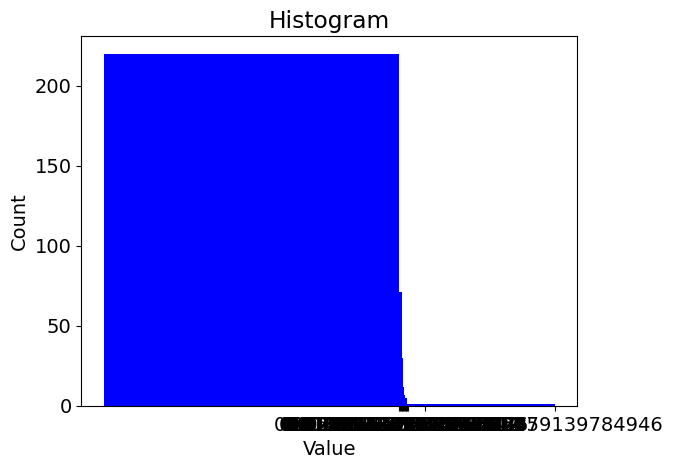


NW 4 DEGREE CENTRALITY
The mean degree centrality is 0.009470386828877471, with stdev 0.023012574441374372
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.43243243243243246
The minimum node is knowledge graph, with value 0.002702702702702703
(0.43243243243243246, 0.06486486486486487, 0.02702702702702703, 0.024324324324324326, 0.021621621621621623, 0.01891891891891892, 0.016216216216216217, 0.013513513513513514, 0.010810810810810811, 0.008108108108108109, 0.005405405405405406, 0.002702702702702703) (1, 1, 1, 4, 5, 12, 35, 63, 36, 28, 8, 177)


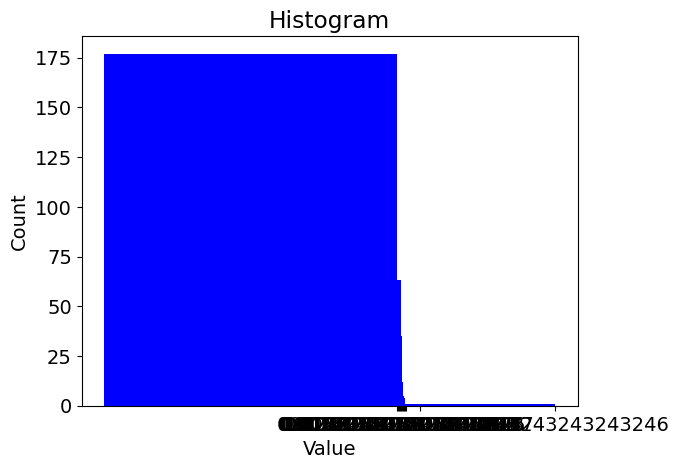


NW 5 DEGREE CENTRALITY
The mean degree centrality is 0.008771603329983457, with stdev 0.021347964513752492
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4089775561097257
The minimum node is knowledge graph, with value 0.0024937655860349127
(0.4089775561097257, 0.08728179551122195, 0.062344139650872814, 0.034912718204488775, 0.02743142144638404, 0.02493765586034913, 0.022443890274314215, 0.0199501246882793, 0.017456359102244388, 0.014962593516209476, 0.012468827930174564, 0.00997506234413965, 0.007481296758104738, 0.004987531172069825, 0.0024937655860349127) (1, 1, 1, 1, 1, 1, 3, 4, 21, 24, 60, 48, 35, 7, 194)


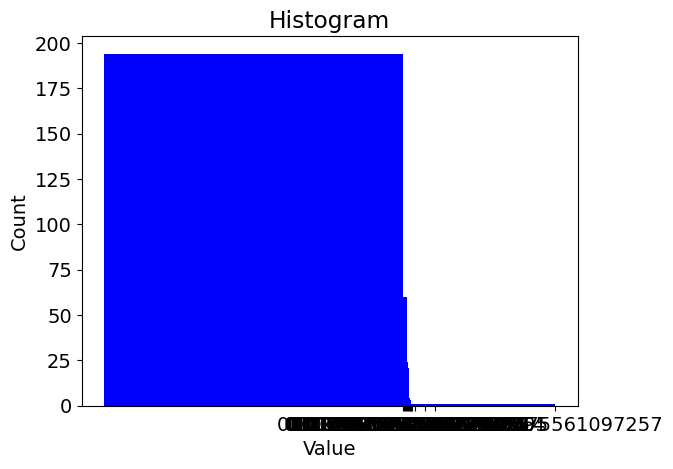


NW 6 DEGREE CENTRALITY
The mean degree centrality is 0.005365127834562849, with stdev 0.01614256506678705
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4128312412831241
The minimum node is knowledge graph, with value 0.001394700139470014
(0.4128312412831241, 0.09065550906555091, 0.048814504881450484, 0.03486750348675035, 0.02789400278940028, 0.02510460251046025, 0.023709902370990237, 0.02092050209205021, 0.019525801952580194, 0.01813110181311018, 0.015341701534170154, 0.01394700139470014, 0.012552301255230125, 0.011157601115760111, 0.009762900976290097, 0.008368200836820083, 0.00697350069735007, 0.005578800557880056, 0.0041841004184100415, 0.002789400278940028, 0.001394700139470014) (1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 6, 9, 10, 24, 55, 140, 75, 33, 16, 336)


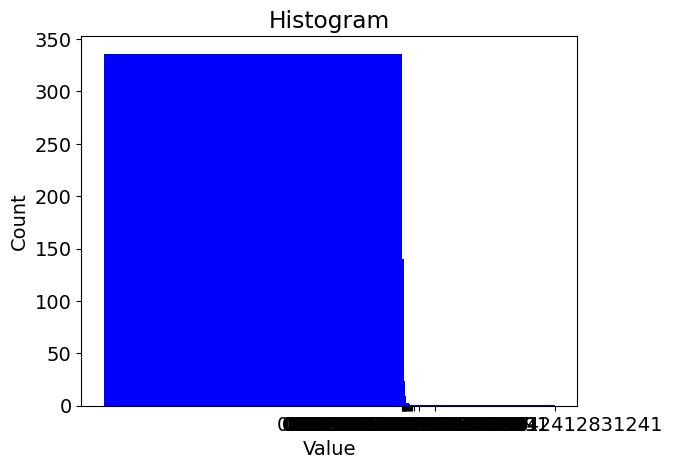


NW 7 DEGREE CENTRALITY
The mean degree centrality is 0.011587848418415233, with stdev 0.0241445985138731
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.40129449838187703
The minimum node is require, with value 0.003236245954692557
(0.40129449838187703, 0.09061488673139159, 0.05177993527508091, 0.04854368932038835, 0.03883495145631068, 0.03236245954692557, 0.025889967637540454, 0.022653721682847898, 0.01941747572815534, 0.016181229773462785, 0.012944983818770227, 0.00970873786407767, 0.006472491909385114, 0.003236245954692557) (1, 1, 2, 1, 1, 2, 5, 16, 20, 50, 25, 30, 11, 145)


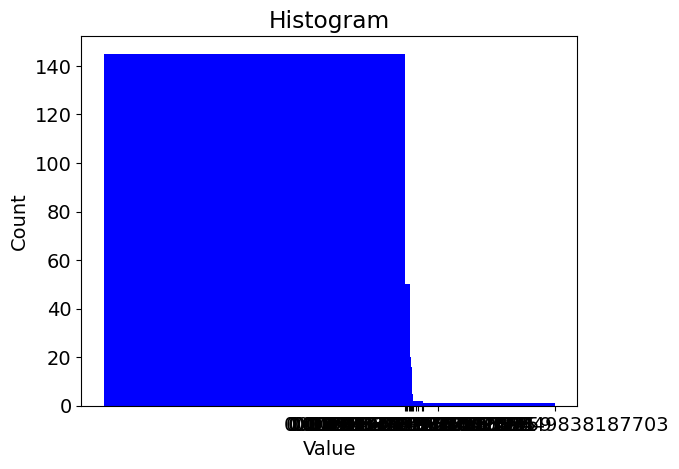


NW 8 DEGREE CENTRALITY
The mean degree centrality is 0.007514104343398698, with stdev 0.019685735497378856
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4198782961460446
The minimum node is knowledge graph, with value 0.002028397565922921
(0.4198782961460446, 0.0872210953346856, 0.036511156186612576, 0.030425963488843813, 0.02636916835699797, 0.02231237322515213, 0.02028397565922921, 0.018255578093306288, 0.016227180527383367, 0.014198782961460446, 0.012170385395537525, 0.010141987829614604, 0.008113590263691683, 0.006085192697768763, 0.004056795131845842, 0.002028397565922921) (1, 1, 1, 2, 1, 5, 5, 5, 10, 14, 35, 79, 57, 36, 8, 234)


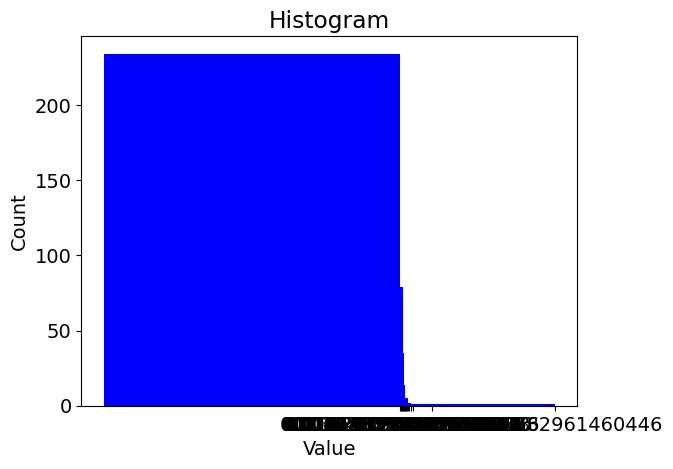


NW 9 DEGREE CENTRALITY
The mean degree centrality is 0.007866708847411126, with stdev 0.020863132213803443
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.42298850574712643
The minimum node is knowledge graph, with value 0.0022988505747126436
(0.42298850574712643, 0.07816091954022988, 0.03908045977011494, 0.029885057471264367, 0.027586206896551724, 0.022988505747126436, 0.020689655172413793, 0.01839080459770115, 0.016091954022988506, 0.013793103448275862, 0.011494252873563218, 0.009195402298850575, 0.006896551724137931, 0.004597701149425287, 0.0022988505747126436) (1, 1, 1, 1, 1, 1, 1, 4, 11, 37, 58, 54, 50, 11, 204)


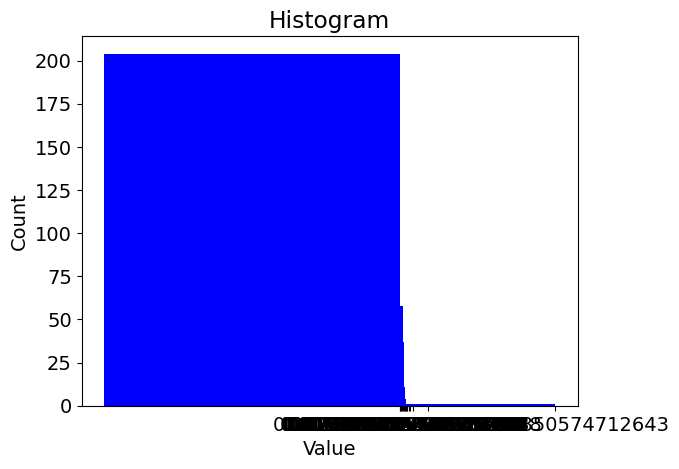


NW 10 DEGREE CENTRALITY
The mean degree centrality is 0.009586945436002125, with stdev 0.022037600266027177
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.40540540540540543
The minimum node is effort, with value 0.002702702702702703
(0.40540540540540543, 0.0945945945945946, 0.02972972972972973, 0.02702702702702703, 0.024324324324324326, 0.021621621621621623, 0.01891891891891892, 0.016216216216216217, 0.013513513513513514, 0.010810810810810811, 0.008108108108108109, 0.005405405405405406, 0.002702702702702703) (1, 1, 2, 4, 6, 4, 11, 27, 60, 46, 25, 1, 183)


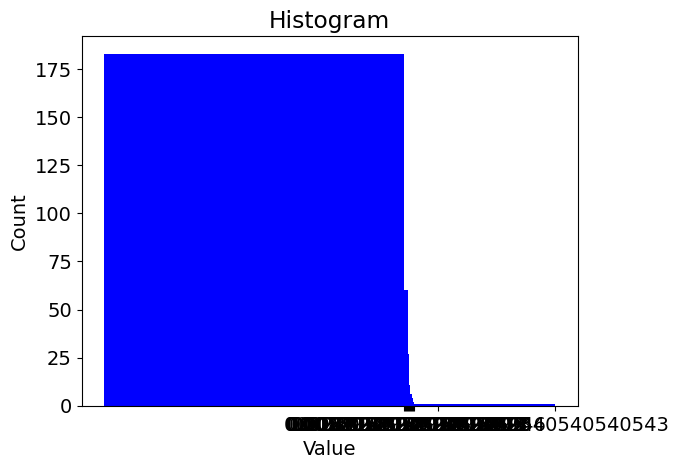


NW 11 DEGREE CENTRALITY
The mean degree centrality is 0.01198418581665437, with stdev 0.02508903653892182
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4084507042253521
The minimum node is explore, with value 0.0035211267605633804
(0.4084507042253521, 0.08098591549295775, 0.03873239436619719, 0.03169014084507042, 0.028169014084507043, 0.024647887323943664, 0.02112676056338028, 0.017605633802816902, 0.014084507042253521, 0.01056338028169014, 0.007042253521126761, 0.0035211267605633804) (1, 1, 1, 1, 6, 5, 25, 43, 32, 26, 13, 131)


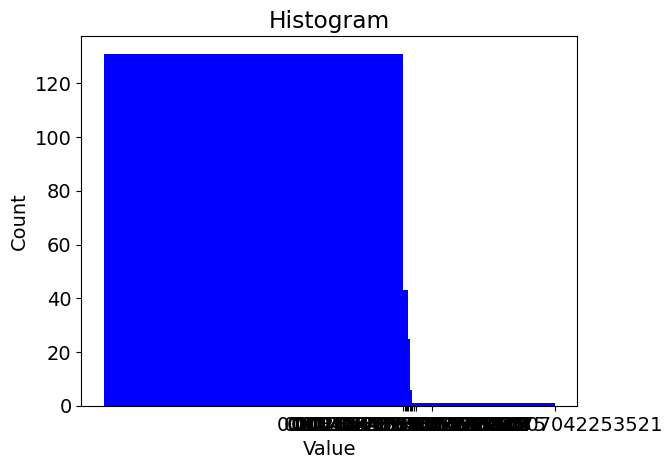


NW 12 DEGREE CENTRALITY
The mean degree centrality is 0.01913199794555734, with stdev 0.03341467833035518
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.42613636363636365
The minimum node is important, with value 0.005681818181818182
(0.42613636363636365, 0.07386363636363637, 0.0625, 0.045454545454545456, 0.03977272727272727, 0.03409090909090909, 0.02840909090909091, 0.022727272727272728, 0.017045454545454544, 0.011363636363636364, 0.005681818181818182) (1, 1, 1, 4, 7, 9, 26, 21, 20, 1, 86)


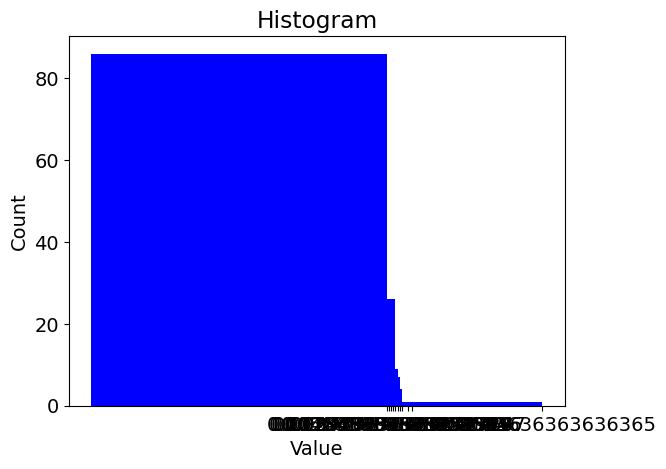


NW 13 DEGREE CENTRALITY
The mean degree centrality is 0.008432156053965868, with stdev 0.020715085865650986
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.41299303944315546
The minimum node is search, with value 0.002320185614849188
(0.41299303944315546, 0.08816705336426914, 0.03480278422273782, 0.030162412993039442, 0.027842227378190254, 0.02320185614849188, 0.02088167053364269, 0.018561484918793503, 0.016241299303944315, 0.013921113689095127, 0.01160092807424594, 0.009280742459396751, 0.0069605568445475635, 0.004640371229698376, 0.002320185614849188) (1, 1, 1, 2, 2, 2, 7, 7, 15, 32, 64, 51, 36, 10, 201)


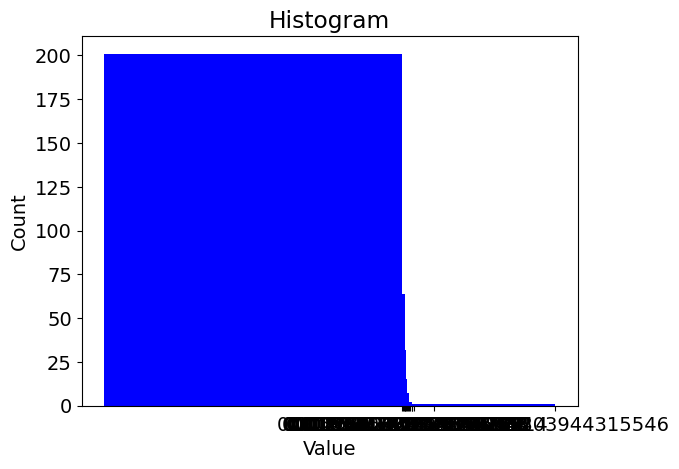


NW 14 DEGREE CENTRALITY
The mean degree centrality is 0.01367917245638411, with stdev 0.027765961466515224
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.42913385826771655
The minimum node is closest, with value 0.003937007874015748
(0.42913385826771655, 0.05905511811023622, 0.047244094488188976, 0.04330708661417323, 0.03937007874015748, 0.03543307086614173, 0.031496062992125984, 0.027559055118110236, 0.023622047244094488, 0.01968503937007874, 0.015748031496062992, 0.011811023622047244, 0.007874015748031496, 0.003937007874015748) (1, 1, 1, 1, 2, 1, 3, 9, 14, 46, 26, 21, 13, 116)


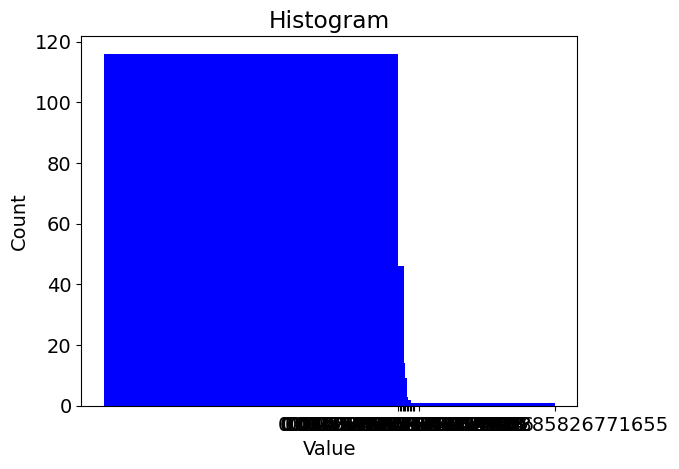


NW 15 DEGREE CENTRALITY
The mean degree centrality is 0.011111111111111084, with stdev 0.023875444144044355
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4031746031746032
The minimum node is knowledge graph, with value 0.0031746031746031746
(0.4031746031746032, 0.09523809523809523, 0.047619047619047616, 0.03492063492063492, 0.02857142857142857, 0.025396825396825397, 0.022222222222222223, 0.01904761904761905, 0.015873015873015872, 0.012698412698412698, 0.009523809523809525, 0.006349206349206349, 0.0031746031746031746) (1, 1, 1, 1, 3, 9, 15, 24, 36, 31, 37, 3, 154)


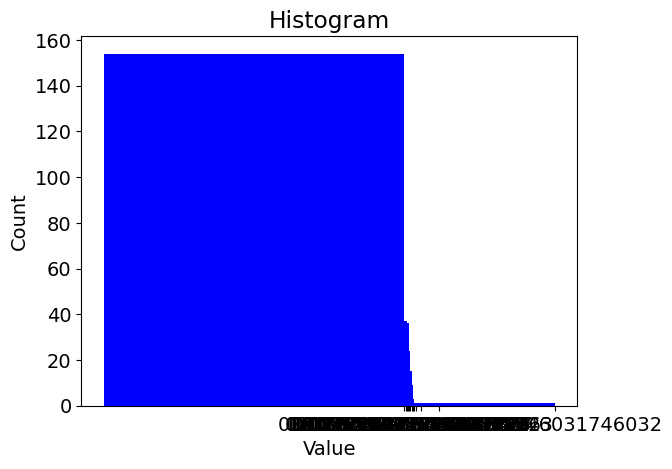


NW 16 DEGREE CENTRALITY
The mean degree centrality is 0.012364670710823493, with stdev 0.02759986133929991
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4389312977099237
The minimum node is knowledge graph, with value 0.003816793893129771
(0.4389312977099237, 0.05343511450381679, 0.03816793893129771, 0.03435114503816794, 0.030534351145038167, 0.026717557251908396, 0.022900763358778626, 0.019083969465648856, 0.015267175572519083, 0.011450381679389313, 0.007633587786259542, 0.003816793893129771) (1, 1, 1, 1, 1, 8, 16, 35, 27, 40, 9, 123)


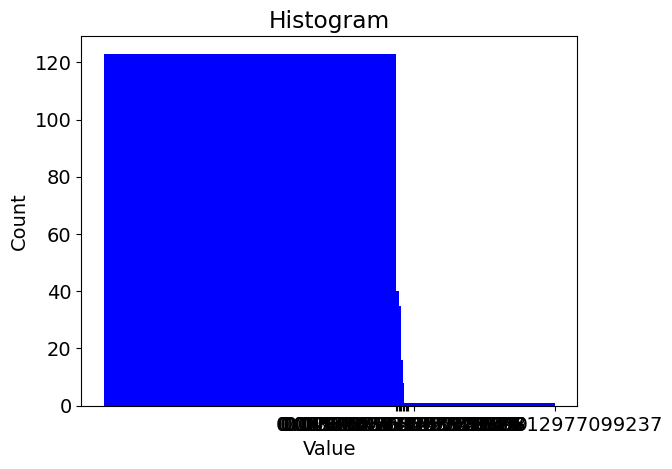


NW 17 DEGREE CENTRALITY
The mean degree centrality is 0.008105798127027665, with stdev 0.019766150567842037
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4034334763948498
The minimum node is stateoftheart, with value 0.002145922746781116
(0.4034334763948498, 0.09442060085836909, 0.060085836909871244, 0.030042918454935622, 0.027896995708154508, 0.02575107296137339, 0.023605150214592273, 0.02145922746781116, 0.019313304721030045, 0.017167381974248927, 0.015021459227467811, 0.012875536480686695, 0.01072961373390558, 0.008583690987124463, 0.006437768240343348, 0.004291845493562232, 0.002145922746781116) (1, 1, 1, 1, 1, 4, 4, 3, 5, 13, 18, 43, 56, 46, 37, 14, 219)


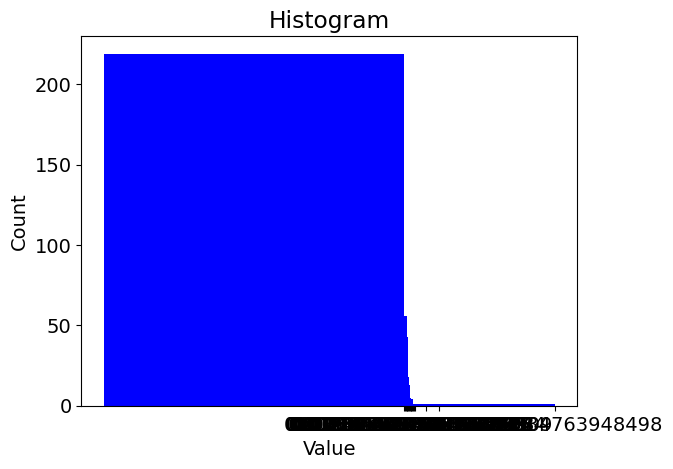


NW 18 DEGREE CENTRALITY
The mean degree centrality is 0.009654049654049578, with stdev 0.022978557117403188
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.41714285714285715
The minimum node is we extend such sequencetosequence models with the idea of infusing structured data from the target knowledge base primarily to enable such sequencetosequence models to handle the nuances of the knowledge base, with value 0.002857142857142857
(0.41714285714285715, 0.07714285714285714, 0.037142857142857144, 0.025714285714285714, 0.022857142857142857, 0.02, 0.017142857142857144, 0.014285714285714285, 0.011428571428571429, 0.008571428571428572, 0.005714285714285714, 0.002857142857142857) (1, 1, 1, 3, 5, 9, 27, 58, 26, 44, 6, 170)


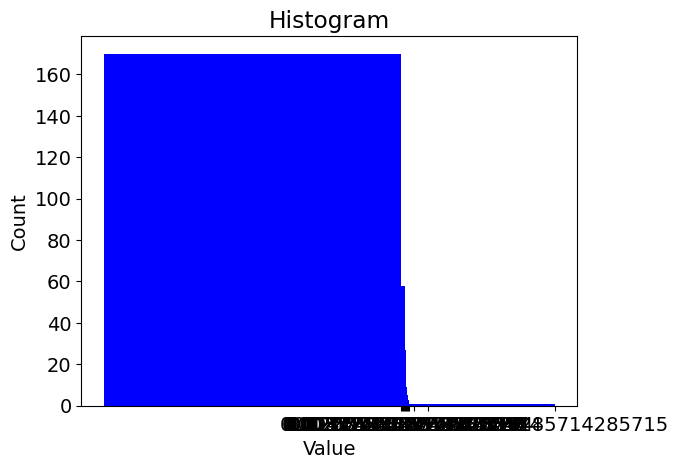


NW 19 DEGREE CENTRALITY
The mean degree centrality is 0.00795008265410448, with stdev 0.019969796757775084
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4113785557986871
The minimum node is snippet, with value 0.002188183807439825
(0.4113785557986871, 0.08096280087527352, 0.03282275711159737, 0.028446389496717725, 0.024070021881838072, 0.02188183807439825, 0.019693654266958426, 0.0175054704595186, 0.015317286652078774, 0.01312910284463895, 0.010940919037199124, 0.0087527352297593, 0.006564551422319475, 0.00437636761487965, 0.002188183807439825) (1, 1, 1, 2, 3, 3, 6, 6, 20, 34, 65, 60, 25, 18, 213)


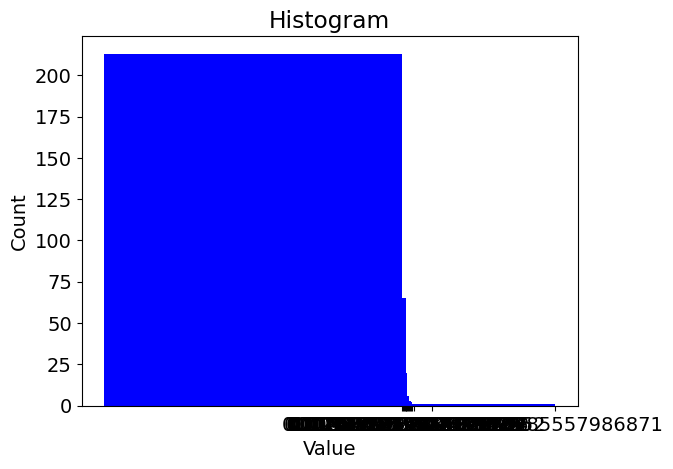


NW 20 DEGREE CENTRALITY
The mean degree centrality is 0.007483414418398968, with stdev 0.019232469952097462
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.39789473684210525
The minimum node is knowledge graph, with value 0.002105263157894737
(0.39789473684210525, 0.10526315789473684, 0.05473684210526315, 0.029473684210526315, 0.021052631578947368, 0.01894736842105263, 0.016842105263157894, 0.014736842105263158, 0.01263157894736842, 0.010526315789473684, 0.008421052631578947, 0.00631578947368421, 0.004210526315789474, 0.002105263157894737) (1, 1, 1, 1, 2, 4, 8, 27, 25, 67, 60, 45, 10, 224)


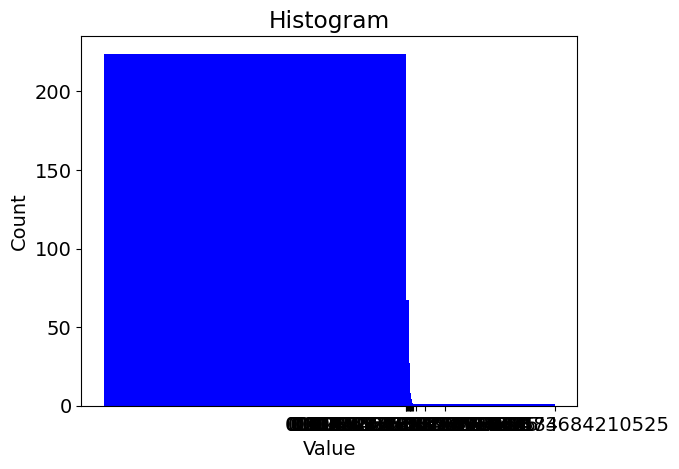


NW 21 DEGREE CENTRALITY
The mean degree centrality is 0.008030086339318794, with stdev 0.02086923770032503
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4216589861751152
The minimum node is in this paper we enrich the framework by extending conjunctive queries in the policy with comparison predicates and introducing preferences between ontology predicates thus in principle augmenting the throughput of query answers, with value 0.002304147465437788
(0.4216589861751152, 0.07603686635944701, 0.03225806451612903, 0.029953917050691243, 0.02534562211981567, 0.02304147465437788, 0.020737327188940093, 0.018433179723502304, 0.016129032258064516, 0.013824884792626727, 0.01152073732718894, 0.009216589861751152, 0.006912442396313364, 0.004608294930875576, 0.002304147465437788) (1, 1, 1, 1, 3, 5, 1, 4, 12, 31, 57, 66, 36, 6, 210)


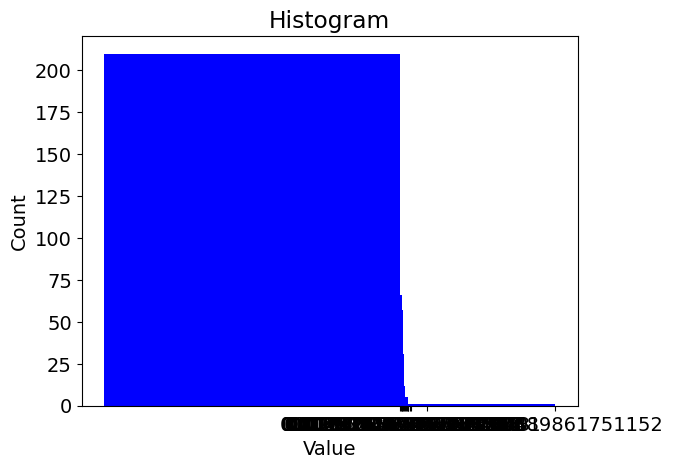


NW 22 DEGREE CENTRALITY
The mean degree centrality is 0.008815775598439289, with stdev 0.020253205457254793
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.3954022988505747
The minimum node is knowledge graph, with value 0.0022988505747126436
(0.3954022988505747, 0.11264367816091954, 0.03908045977011494, 0.034482758620689655, 0.03218390804597701, 0.02528735632183908, 0.022988505747126436, 0.020689655172413793, 0.01839080459770115, 0.016091954022988506, 0.013793103448275862, 0.011494252873563218, 0.009195402298850575, 0.006896551724137931, 0.004597701149425287, 0.0022988505747126436) (1, 1, 1, 1, 2, 2, 8, 10, 11, 22, 22, 59, 54, 31, 10, 201)


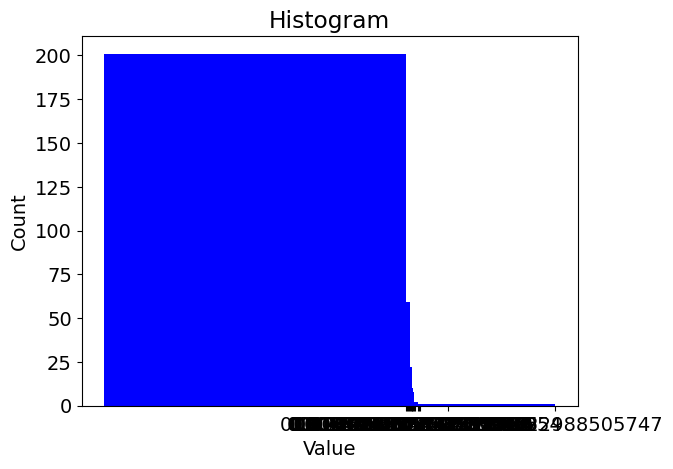


NW 23 DEGREE CENTRALITY
The mean degree centrality is 0.008474274523767141, with stdev 0.020617307541528403
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4
The minimum node is knowledge graph, with value 0.0024390243902439024
(0.4, 0.1024390243902439, 0.026829268292682926, 0.02195121951219512, 0.01951219512195122, 0.01707317073170732, 0.014634146341463414, 0.012195121951219513, 0.00975609756097561, 0.007317073170731707, 0.004878048780487805, 0.0024390243902439024) (1, 1, 1, 2, 4, 17, 36, 69, 41, 38, 2, 199)


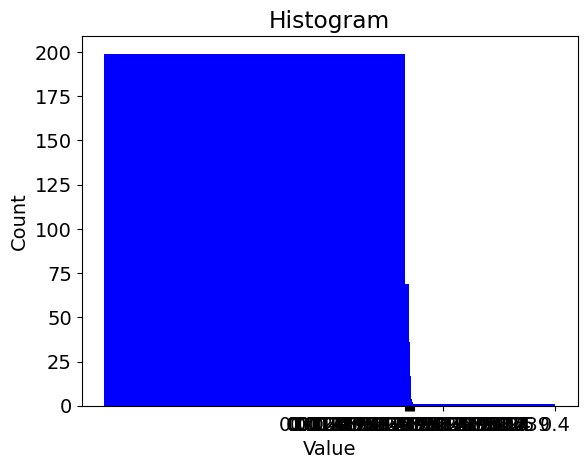


NW 0 PAGERANK
The mean network pagerank is 0.0030674846625766863, with stdev 0.006530176471029457
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.1198263734701479
The minimum node is http://local/local.owl#thousand_of_real_rdf_datasets, with value 0.0019529170689229249
(0.1198263734701479, 0.009732053469594965, 0.007222032644075744, 0.006185052963102008, 0.005606014265480225, 0.004909754051601971, 0.004791497552255414, 0.004535521497068875, 0.004506156898211186, 0.004392319668748984, 0.004335574732099652, 0.004167336424344763, 0.004013192604858921, 0.003989312450032832, 0.0038919132828954387, 0.003880081897211615, 0.0038688348976738053, 0.0037239714271266504, 0.0036581931175746363, 0.003647585905146694, 0.003640768310328901, 0.0036353761716550687, 0.003608935964202297, 0.0036066142509321845, 0.003556306626623169, 0.0035028729560033747, 0.003499735668335812, 0.0034975213416219113, 0.0034872929359899547, 0.003486669298249073, 0.0034640904948517997, 0.0

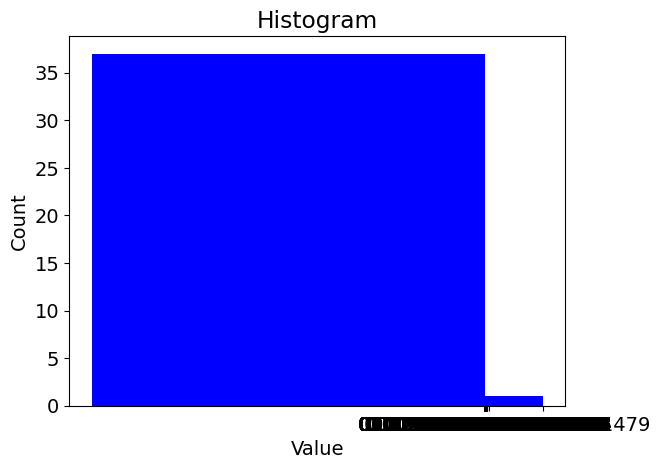


NW 1 PAGERANK
The mean network pagerank is 0.002487562189054728, with stdev 0.005390530644178382
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.10926325259676908
The minimum node is http://local/local.owl#s8, with value 0.0015780852525919351
(0.10926325259676908, 0.011964334324951864, 0.004637929196671771, 0.004535136178653391, 0.0042517243268639605, 0.0041923994712149415, 0.004039167778806134, 0.004027226314850189, 0.0040094394202519045, 0.0040034522953230145, 0.00399644370337874, 0.003952073130307622, 0.003831775178159588, 0.0037389518935225003, 0.003714684783546517, 0.0036872086208722945, 0.0036839864716404036, 0.0036712040447924935, 0.0035729538212062343, 0.003549625890637846, 0.0035348297397541795, 0.003514522838885214, 0.0035112512451273264, 0.003505938541767354, 0.003475998046378337, 0.0033600680604367133, 0.0032899493822551337, 0.0032815506072715037, 0.003277519014726721, 0.003274196233590899, 0.0031474108591044944, 0.0031383420723519765, 0.

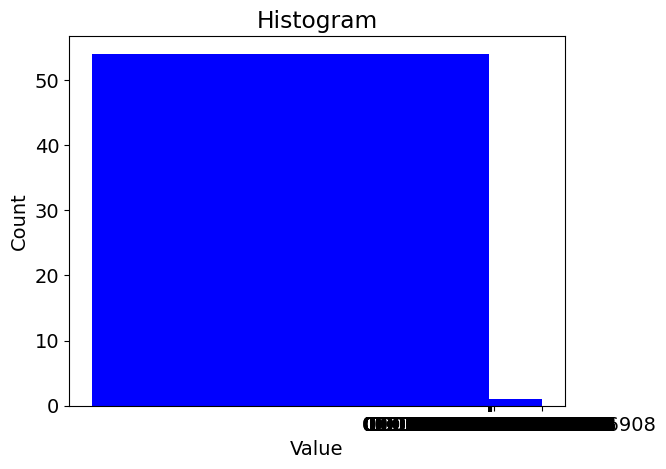


NW 2 PAGERANK
The mean network pagerank is 0.002352941176470594, with stdev 0.005732746840545794
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11960811212268466
The minimum node is http://local/local.owl#set_of_feature, with value 0.0014892540427225395
(0.11960811212268466, 0.008661712163302082, 0.004995373751684104, 0.004884790482924238, 0.004683519280041189, 0.004220461997114821, 0.004108716783470665, 0.00370440917402684, 0.0036457277113744915, 0.003639094872825556, 0.0036124462146802263, 0.0035650976603821467, 0.003553327509952134, 0.0035156870521244206, 0.003480080533222341, 0.003283217843948248, 0.0032351894734142634, 0.0031992550762164995, 0.003196993986571631, 0.003176226618400807, 0.0030679785485222917, 0.0030355774594625295, 0.00302503577766837, 0.0029832673035445657, 0.002847530856259555, 0.002839944355478143, 0.002839363806596336, 0.00283930558473762, 0.0028355009835106817, 0.0028302859285133817, 0.0027919794595808265, 0.0027748048487557

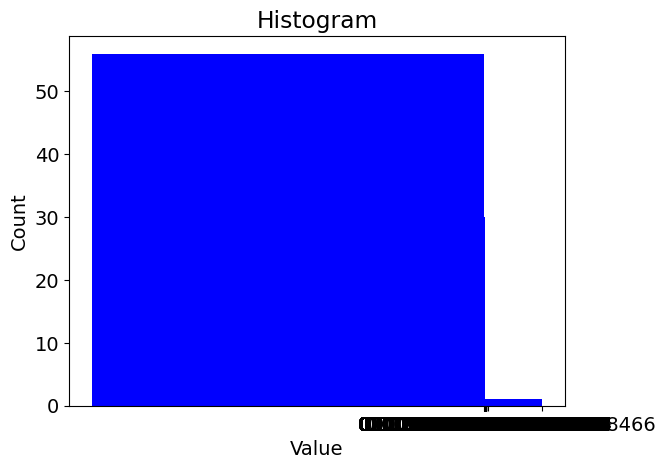


NW 3 PAGERANK
The mean network pagerank is 0.0021459227467811107, with stdev 0.0053934230861119505
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11764784516120937
The minimum node is http://local/local.owl#s9.1, with value 0.0013592142949875622
(0.11764784516120937, 0.009399668793224321, 0.005225816236567147, 0.0044068740178525, 0.004085277731804478, 0.0038386327308343898, 0.00360830058990877, 0.0035801270832178217, 0.0034970751350437987, 0.0034341387615436036, 0.003313601879607582, 0.003232359293786831, 0.0032024540420560826, 0.0031977315047686337, 0.003095499060614423, 0.0030746130980183963, 0.0030680580079135455, 0.0030481113468709305, 0.003031930456456699, 0.003014676329041798, 0.0030101122942379484, 0.002989914515765824, 0.002845938454625551, 0.0028405411443442287, 0.0027630792309375667, 0.0027550899544960647, 0.002727097487713684, 0.00271827151098988, 0.0026672410590726117, 0.0026663462246184003, 0.0026397344651472145, 0.0026385768617502255, 

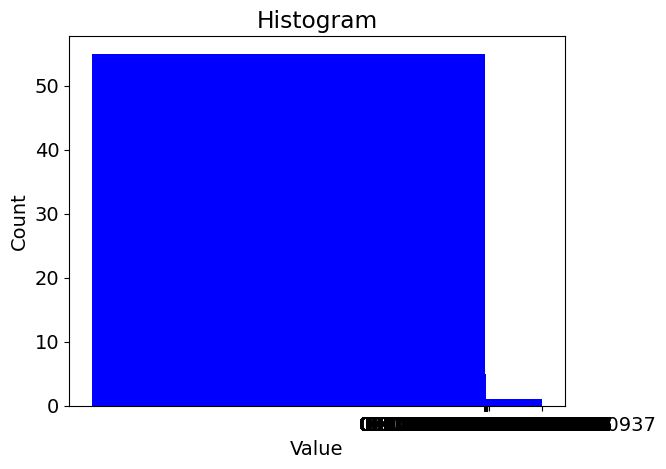


NW 4 PAGERANK
The mean network pagerank is 0.0026954177897574095, with stdev 0.006168314762464648
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.1205984931299296
The minimum node is http://local/local.owl#s4, with value 0.0017156528028671664
(0.1205984931299296, 0.008378520833671941, 0.005319814147316808, 0.005082193626932362, 0.004455134237774726, 0.004085106951888515, 0.004054710128674616, 0.003976616040851139, 0.0038746521017847717, 0.003835257231632536, 0.0038321634197695633, 0.0038278058987064618, 0.0038207466618310273, 0.003577893474962025, 0.00356126920457109, 0.0034518923008529734, 0.003438760023539181, 0.003427984482424644, 0.003410930439163664, 0.003348197117822479, 0.00334535653855122, 0.0033442263678465835, 0.003340710954601523, 0.003275786695118456, 0.0032478890559392093, 0.003236119224569005, 0.0032291298858566353, 0.0032108789405997365, 0.0031519332755382025, 0.003138224158954553, 0.003136072375251129, 0.003131950556191607, 0.00310750

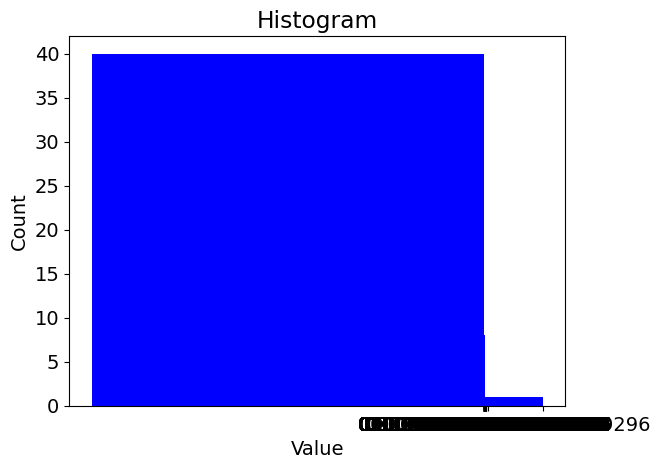


NW 5 PAGERANK
The mean network pagerank is 0.002487562189054721, with stdev 0.005831585681427475
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11802584697765497
The minimum node is http://local/local.owl#s3.2, with value 0.0015859681099105326
(0.11802584697765497, 0.010798216657872558, 0.010682446046027754, 0.006175407732678198, 0.004936034700601352, 0.004706803800271976, 0.0044022399444454945, 0.004048103745490185, 0.003858058195625188, 0.003694183131559848, 0.0036705941216947117, 0.0036417676991676623, 0.0035861668124410433, 0.003515514205051976, 0.003456242759635442, 0.0034499775294942435, 0.0032710954622258265, 0.0031555361658575907, 0.0031451037450636204, 0.0031041876101869778, 0.003053816630487034, 0.003052160452797795, 0.0029766050328696152, 0.0029754913315167704, 0.0029595255944498905, 0.0029502603540122563, 0.002945698021116364, 0.00288424838959158, 0.0028436438502824827, 0.0028426723451052153, 0.002839647523596383, 0.002838070423538243, 0

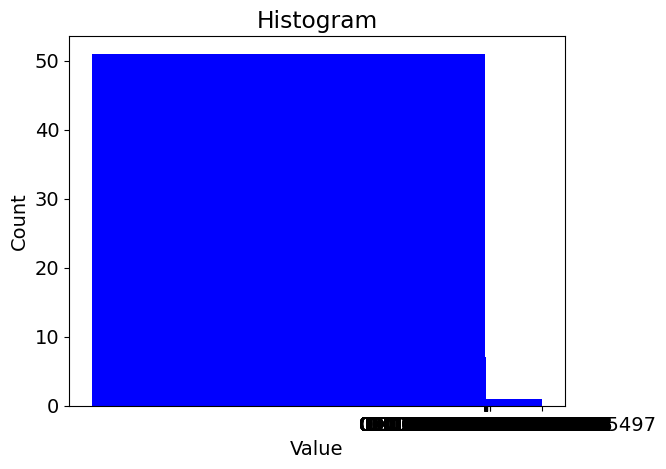


NW 6 PAGERANK
The mean network pagerank is 0.001392757660167128, with stdev 0.004194114537639835
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11237656530602755
The minimum node is http://local/local.owl#s2.1, with value 0.0008614161335763837
(0.11237656530602755, 0.01038915923614285, 0.006428162392936376, 0.0056182852665322795, 0.004662751678498, 0.0045130519408107545, 0.004487634393561306, 0.004198591947232366, 0.003593374732067775, 0.003472000920531935, 0.003352435718918581, 0.003339648110550884, 0.00324955285852948, 0.0031111314254213237, 0.0029296677945266276, 0.002895147915564143, 0.0028935722966168644, 0.002845414065109613, 0.002800945730861517, 0.0027803454851144816, 0.002770978723423914, 0.0026545321964835072, 0.002645815573661363, 0.0025481763090052074, 0.0024124559388868606, 0.002372692573542406, 0.002286892152403129, 0.0022806894481942896, 0.0022459120893861192, 0.00222519171908799, 0.0021980604968083552, 0.002173691038225842, 0.0021722

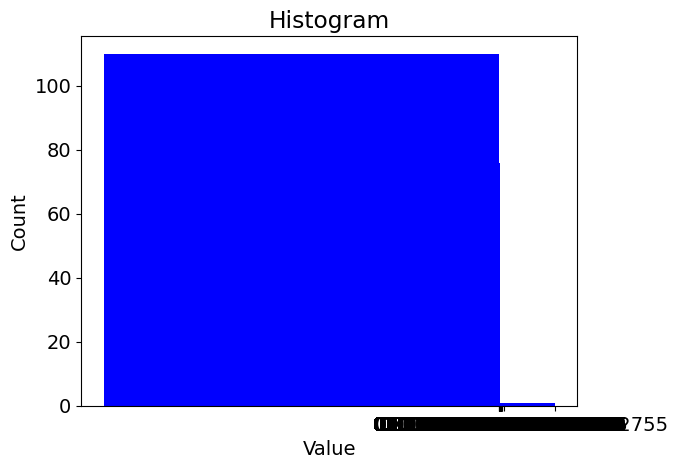


NW 7 PAGERANK
The mean network pagerank is 0.003225806451612898, with stdev 0.006264640860442891
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11155349485490544
The minimum node is http://local/local.owl#s2, with value 0.002028426985386019
(0.11155349485490544, 0.012856399932578267, 0.009229737879041678, 0.007871865338417008, 0.006923341882923441, 0.006721762297645484, 0.0066419127551892755, 0.005951901085317283, 0.005877486778196263, 0.0058676346244212, 0.0058420088111021265, 0.005592981014051699, 0.005374510579970895, 0.004971192384532658, 0.004898597736244542, 0.004748223778662781, 0.004745817398147597, 0.004697450997347897, 0.004662806539154846, 0.004526987889790755, 0.004264938126325172, 0.004196073820426, 0.004110786676964577, 0.004091416933339222, 0.004045411852726803, 0.004025291707644171, 0.003954555091796267, 0.0038411978736511846, 0.003709431785178053, 0.003509694495949225, 0.0034921401336291107, 0.003447495146753484, 0.00341668346821963

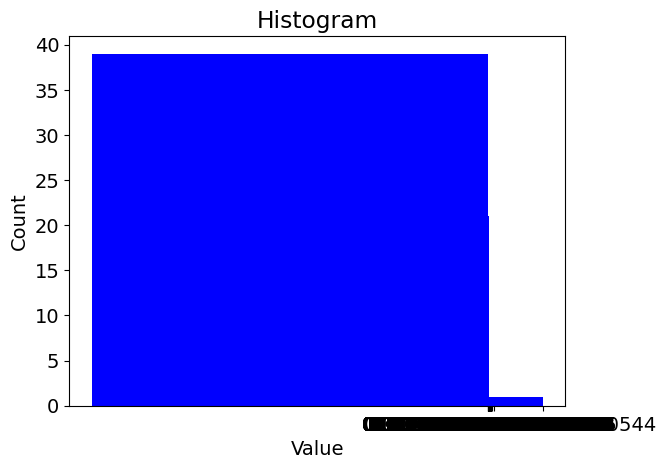


NW 8 PAGERANK
The mean network pagerank is 0.002024291497975709, with stdev 0.005273405502136266
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11808662619561351
The minimum node is http://local/local.owl#answer_bias_issue, with value 0.001272698636721479
(0.11808662619561351, 0.0107777288046184, 0.0059922838757566895, 0.0048915623507602216, 0.004307289394686038, 0.004057649456088042, 0.003819898304310571, 0.003793575562377738, 0.0036706761882608365, 0.0034725858697845563, 0.0034186104011524484, 0.00335193940691843, 0.0032399749944764487, 0.00323271696944639, 0.003140826878985865, 0.003102941475714445, 0.0030240712574377882, 0.0030153268774405577, 0.0029975387399701512, 0.002957651451292918, 0.0029131113485782547, 0.0029042564744157606, 0.002832399786301635, 0.0027850594870609375, 0.0027632078342913536, 0.002725447934266487, 0.0027131278583586026, 0.002684384135966332, 0.002650008694274236, 0.0026463758942529025, 0.0025967390024498613, 0.00259392760

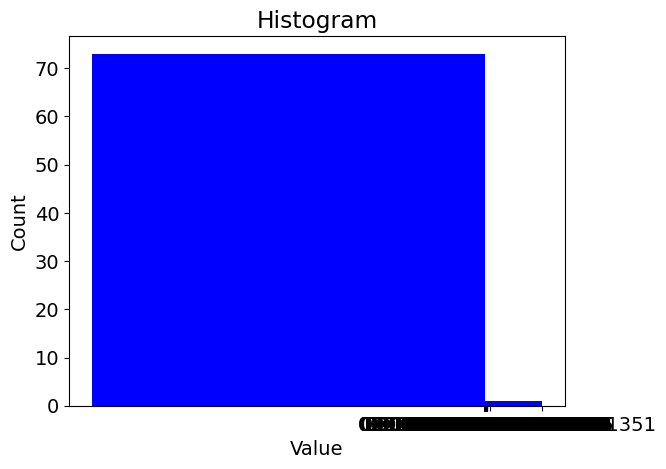


NW 9 PAGERANK
The mean network pagerank is 0.0022935779816513806, with stdev 0.005758195518178943
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.12161869803001757
The minimum node is http://local/local.owl#s2, with value 0.001468333642115394
(0.12161869803001757, 0.00925453157890355, 0.006955999781638284, 0.004424780743762172, 0.004030334204212822, 0.003827539462451868, 0.0036540870462697275, 0.0035642664031495137, 0.0035311735226080465, 0.003471347920510515, 0.003414925175644408, 0.0033091045008514885, 0.0031812946038624525, 0.0030854265995897434, 0.003075969013214543, 0.0029729592796178283, 0.0029429952404613565, 0.0029199905487814074, 0.0027798921681622644, 0.00277729172844853, 0.002775379744676185, 0.0027317590408377783, 0.0026953373491805876, 0.0026681076544569867, 0.002648557561642952, 0.002633364701223123, 0.002602037219863929, 0.002587559291563908, 0.0025611348367733113, 0.002552253040486636, 0.0025505652392817124, 0.0025446207302973027, 0.0

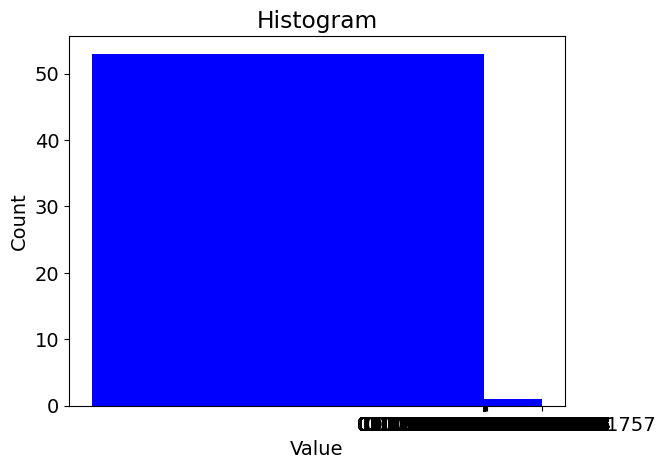


NW 10 PAGERANK
The mean network pagerank is 0.002695417789757406, with stdev 0.005976558333995159
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11644910089121395
The minimum node is http://local/local.owl#s13.1, with value 0.0017080297884563044
(0.11644910089121395, 0.012648032168209847, 0.0056350998006229995, 0.00543673427661533, 0.005080586202964152, 0.004989873591097044, 0.004648835889738724, 0.004489392411307976, 0.0043627311911633515, 0.004102302449856758, 0.0040752513787417856, 0.004016500604528729, 0.003866553921884284, 0.003859266545276893, 0.0038408088044252246, 0.0038277146930751167, 0.0037774702212439223, 0.003760279098460745, 0.0036836763780411404, 0.003646597620504282, 0.0036154116233071912, 0.003615049191710935, 0.003607074454029602, 0.003439310789030282, 0.0034313433232573513, 0.0033561451932996754, 0.003333939910071893, 0.003312473696459618, 0.003306119640290926, 0.0032575412424256074, 0.003249800457067479, 0.0032413793742841913, 0.

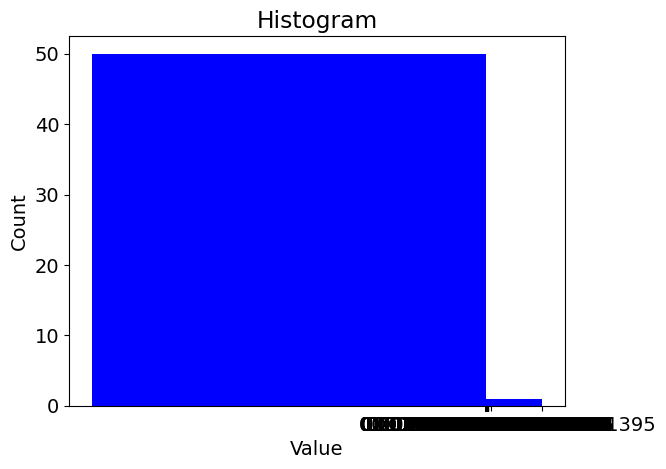


NW 11 PAGERANK
The mean network pagerank is 0.00350877192982457, with stdev 0.006772863040848942
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11645121856342347
The minimum node is http://local/local.owl#s11.1, with value 0.002240254093569486
(0.11645121856342347, 0.010656343107118051, 0.0076995826578196164, 0.006443040449946033, 0.006239468392800034, 0.005968929369167508, 0.005658312299581618, 0.0055817710719249115, 0.005512484483762986, 0.0054129425012387255, 0.005271028066184018, 0.005048830175312694, 0.004968901565015562, 0.0048166881713740195, 0.004801770653812035, 0.004612202419017876, 0.0045405393645137, 0.004531083859013756, 0.004479489189260759, 0.004426197144171684, 0.004385771520769588, 0.004335075801812752, 0.004286780824402828, 0.0041656074728129485, 0.00412098704289388, 0.004082116460934002, 0.0040390258506310586, 0.0040088991403818795, 0.003997411648948006, 0.0039438279927583334, 0.0038815512852090088, 0.003863616090794909, 0.0038215

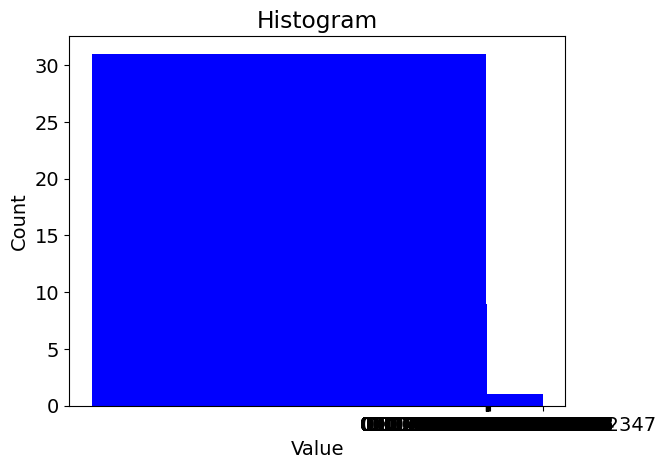


NW 12 PAGERANK
The mean network pagerank is 0.005649717514124295, with stdev 0.009014880165727658
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.12369758436507658
The minimum node is http://local/local.owl#s4, with value 0.0036364066512398667
(0.12369758436507658, 0.012136832637393992, 0.010431692955790951, 0.00952040685395796, 0.008737244368873597, 0.008355117237031926, 0.008138296858061538, 0.00806969601865313, 0.0076824647682041825, 0.007349644277451417, 0.007188901313695161, 0.0071873426956916755, 0.007095240448636058, 0.006784634865581736, 0.006657102243466486, 0.0066032970501165925, 0.006519667207639919, 0.00650800619839797, 0.006465877396077076, 0.0064427098574725665, 0.0064312449252884474, 0.0064022838575594435, 0.006282214413537948, 0.006258284838306519, 0.006246871040629209, 0.006225413206559147, 0.006169242819955886, 0.006142156091554133, 0.006042846515264915, 0.005931744425084094, 0.005845506354702466, 0.005831188062707221, 0.00580659178

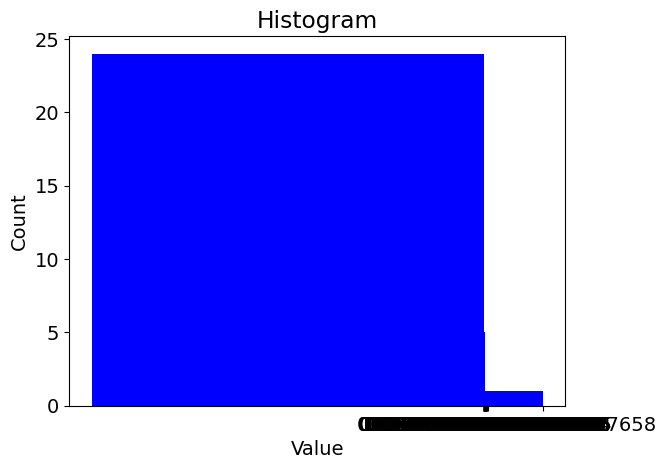


NW 13 PAGERANK
The mean network pagerank is 0.0023148148148148112, with stdev 0.005480048013809241
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11492779461864394
The minimum node is http://local/local.owl#do_not_presuppose, with value 0.001454332578233431
(0.11492779461864394, 0.011797529853956998, 0.005514466095071159, 0.005249286277710912, 0.0048251476985092774, 0.004573606900501715, 0.004247755634005253, 0.00417888057551515, 0.004053798156701287, 0.00390957030624299, 0.0037970741651247985, 0.003684912273081564, 0.003660227474948305, 0.0035836570233847326, 0.0035051896200621463, 0.0034366279200681127, 0.0033996761798631304, 0.0033656778186084376, 0.0033488816047527125, 0.003342997907117899, 0.0033086906555543894, 0.0032480977271412722, 0.003177462353576033, 0.003163975046910488, 0.003116238778569404, 0.0030174253959096573, 0.003015954000464054, 0.003009490730286451, 0.003009308251336267, 0.002996904314873065, 0.0029153237885642985, 0.00288433151

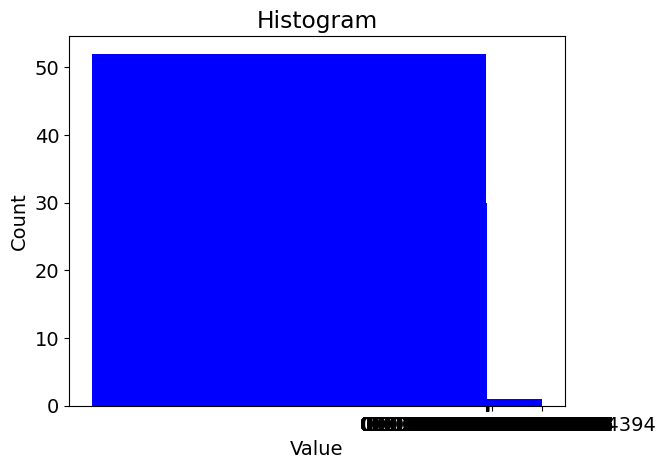


NW 14 PAGERANK
The mean network pagerank is 0.003921568627450977, with stdev 0.007021673462316216
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.1145661459212412
The minimum node is http://local/local.owl#s8, with value 0.0024677893138226985
(0.1145661459212412, 0.008551092986491867, 0.008455159064719081, 0.008406685878977622, 0.007425087989126067, 0.007334627293055478, 0.0069040160112822085, 0.0061539792745926416, 0.006106051807151904, 0.005888198971174557, 0.00587612095194136, 0.005694145354462529, 0.005605743483145662, 0.0050622171747843605, 0.004951879541502704, 0.004905032777688031, 0.004571285027985143, 0.004552225669904458, 0.0045452126944913055, 0.004539258499314891, 0.00446504713046738, 0.004453649270181817, 0.004441917379176424, 0.004396692480319261, 0.004355614141602488, 0.0042979170275232745, 0.004294413339725248, 0.0042590847059062594, 0.004254986141233999, 0.0042549798901576254, 0.004254623597787726, 0.004235980966233275, 0.00421508460

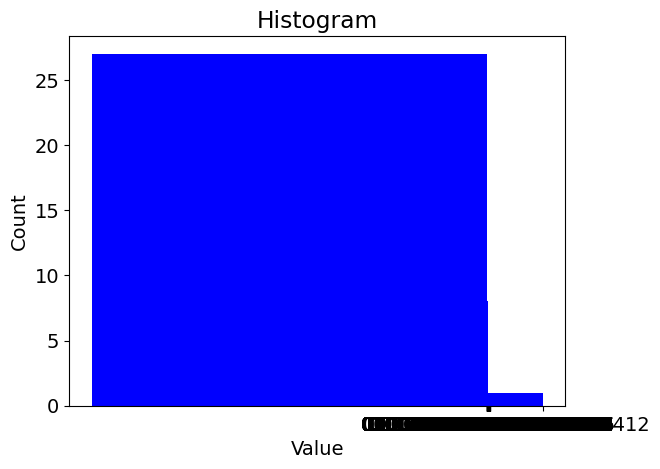


NW 15 PAGERANK
The mean network pagerank is 0.0031645569620253142, with stdev 0.006568202840451223
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11846242930135126
The minimum node is http://local/local.owl#s6.2, with value 0.0020260403326404913
(0.11846242930135126, 0.012738521806029884, 0.007559564321791592, 0.005869371549185237, 0.00523724718779008, 0.005185814453992166, 0.0049602439825033, 0.00493061775226372, 0.004640523660669096, 0.004616109610996948, 0.004520293127426337, 0.004513569678348949, 0.0044466653141041965, 0.004446372289478957, 0.004230898042193011, 0.00412131856384186, 0.004080376492704831, 0.004020394951888582, 0.003997951731574612, 0.003995361079177226, 0.003987108747521399, 0.003944150570679371, 0.003937180949407549, 0.0039153629359196754, 0.003910381636601555, 0.0038241370987760954, 0.0038200805993248805, 0.0038047358214739224, 0.003772798978623394, 0.0037589310478601343, 0.0037234773232673016, 0.003701040729519351, 0.003699240

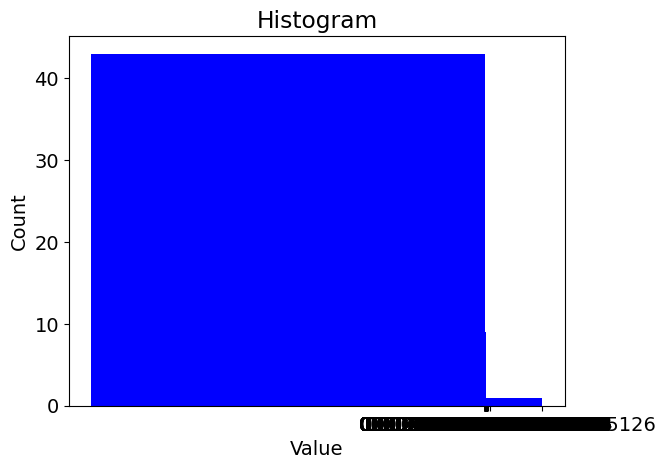


NW 16 PAGERANK
The mean network pagerank is 0.0038022813688212923, with stdev 0.007373825456199542
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.12231800179162199
The minimum node is http://local/local.owl#no_datasetspecific_optimization, with value 0.0024482233144663256
(0.12231800179162199, 0.008415029496376908, 0.006398098689459591, 0.006274314545361581, 0.00617638831376586, 0.006152009607760324, 0.00562272262960453, 0.005567107353595328, 0.0051669653088643065, 0.005134990250109632, 0.004954692223839476, 0.004814023622427844, 0.004787512833421414, 0.0046304380170164834, 0.004482769042411258, 0.004335315361174025, 0.004323485707631536, 0.004290949621700962, 0.004285515268152435, 0.00422137753979376, 0.00417228360388789, 0.004144115072853135, 0.0041376246022536405, 0.004137250209252065, 0.004116340035518368, 0.004088183494305652, 0.004059173126333011, 0.0040430125011442445, 0.004030910350403258, 0.004028001785199329, 0.004026325521833233, 0.004022

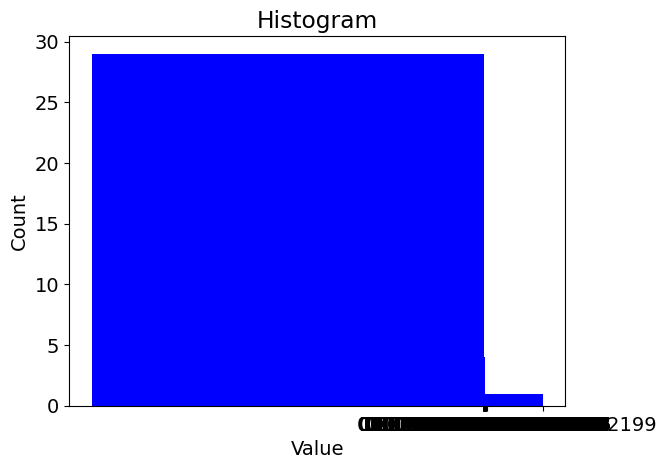


NW 17 PAGERANK
The mean network pagerank is 0.002141327623126339, with stdev 0.005265742258992387
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11461105573405073
The minimum node is http://local/local.owl#s21, with value 0.0013464509774147276
(0.11461105573405073, 0.010522184849493157, 0.008195816407008507, 0.004831370629178965, 0.004440910642587007, 0.004364849501802788, 0.004303853972481365, 0.0041715900071221095, 0.004101364114812501, 0.00391053154716912, 0.0036207375637465128, 0.003598874423582789, 0.0035727445466502156, 0.003559640371026608, 0.003525772179912668, 0.0034847083632875645, 0.003461001785852189, 0.00342983708527629, 0.003338410373435014, 0.0032347113856205654, 0.003229438217609971, 0.0032262776911125063, 0.003119624766642297, 0.003108137512573719, 0.0030902102035701264, 0.002996046742225978, 0.0029903418458017477, 0.002981416377567229, 0.002885598016591563, 0.002784558267387014, 0.0027659395321324278, 0.0027336334918401928, 0.00271

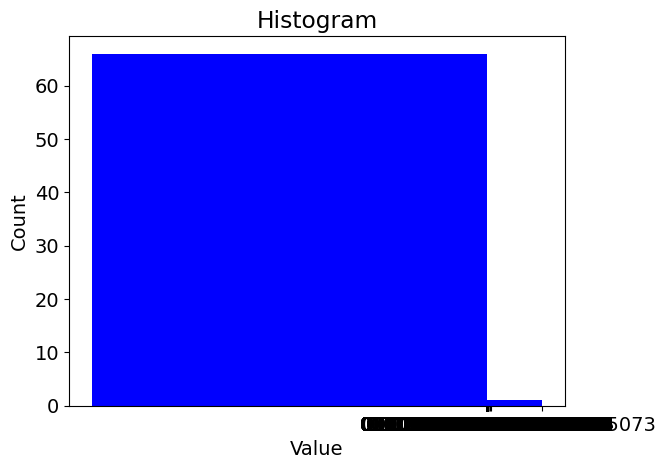


NW 18 PAGERANK
The mean network pagerank is 0.0028490028490028483, with stdev 0.006239845740536063
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11865437677539033
The minimum node is http://local/local.owl#s7, with value 0.0018249868117256383
(0.11865437677539033, 0.010594365691859736, 0.0052239077429597595, 0.005063429490996533, 0.00502005643493851, 0.004944755078558499, 0.004943721457357876, 0.004820203493402419, 0.004495600964421511, 0.0042849874251661485, 0.003977193890347521, 0.003926284380570998, 0.003925660645029989, 0.0039253136095650535, 0.0037861123926208637, 0.003646572974984704, 0.003646170869731817, 0.0035814481015735613, 0.003524347175546028, 0.0035185115253462667, 0.003493072204234765, 0.0034429261333342033, 0.0034339505263398747, 0.0034144335439530394, 0.003373914448574755, 0.003350577998539194, 0.0033225650574777465, 0.0033202837882694534, 0.0032922054619156237, 0.0032882840111464044, 0.003287897110032415, 0.0032762251777193013, 0.

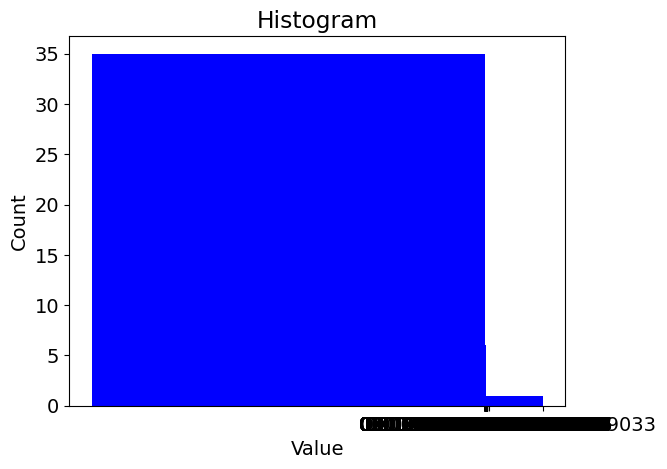


NW 19 PAGERANK
The mean network pagerank is 0.0021834061135371148, with stdev 0.005263214252405491
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11365188730831483
The minimum node is http://local/local.owl#s7.1, with value 0.0013751605709474185
(0.11365188730831483, 0.010202347562608535, 0.005655448585696446, 0.005110259511567445, 0.004553711768894497, 0.004426927594013958, 0.0038005385808895288, 0.0037790265128290843, 0.0037317277989596053, 0.0036918065719811887, 0.003679002526677023, 0.003563433263687835, 0.003546156134130082, 0.0035446701001451424, 0.0035223644792926907, 0.003492432564766638, 0.0033181556774558385, 0.003309633970765348, 0.003255404715186246, 0.0031577564160092885, 0.0031160978574268166, 0.003091055504057644, 0.0029998284756864962, 0.002996166302869692, 0.0029909062563953964, 0.0029717389744279288, 0.0029452123637674797, 0.002915629007962551, 0.002914316934305009, 0.002889438761334002, 0.0028562017168566474, 0.0028485729863689546

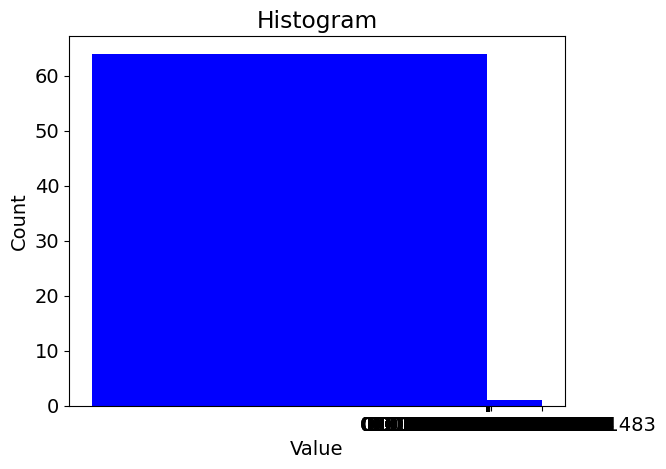


NW 20 PAGERANK
The mean network pagerank is 0.0021008403361344563, with stdev 0.005266279767489466
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11563008453242835
The minimum node is http://local/local.owl#s17, with value 0.0013305440426438179
(0.11563008453242835, 0.013208059509788686, 0.007515368317729623, 0.004826787327518861, 0.004350973334860732, 0.003985046667978605, 0.003356912496607611, 0.0033371776867189254, 0.003331960049437635, 0.003246601649936549, 0.0031965876197763044, 0.0031802543011121526, 0.0031400408447116836, 0.0030634275794142692, 0.002995324995478261, 0.002973680813898096, 0.0028982850774570998, 0.0028799308397485317, 0.002875930826855257, 0.0028701468637097943, 0.002866039255561477, 0.002849400675110298, 0.0028474170891281377, 0.0027574574021154473, 0.002749530077715096, 0.002746908109184955, 0.002710584942497577, 0.0026891015999495117, 0.002665068575505284, 0.0026577953553112116, 0.0026084390191714654, 0.0026066171266577783, 

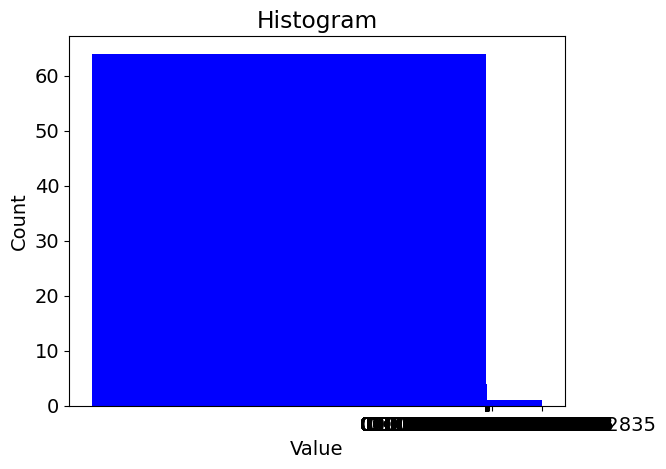


NW 21 PAGERANK
The mean network pagerank is 0.0022988505747126423, with stdev 0.005668079847114121
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.1195280631871916
The minimum node is http://local/local.owl#typically_constitute_by_conjunctive_query, with value 0.001466893585491363
(0.1195280631871916, 0.009520686555642118, 0.0046046137745130705, 0.004376032677110229, 0.00428410955815959, 0.004204608008813093, 0.004152400013968265, 0.00409706703611929, 0.003959536728240153, 0.0036080589374952276, 0.0035759455377596763, 0.00353295811687053, 0.003413747710705532, 0.003286911492119066, 0.0032827284915137693, 0.0032723474702344266, 0.0032548763050112253, 0.0032314780570876834, 0.0032163358723073902, 0.0032072775090434295, 0.0031789787290665613, 0.003177509400206796, 0.0031492317366495597, 0.003112003437178903, 0.0030772219037805662, 0.0029679563601921056, 0.0029178427056752807, 0.0028729036984957807, 0.002833630747742698, 0.0028336307477426974, 0.00282342

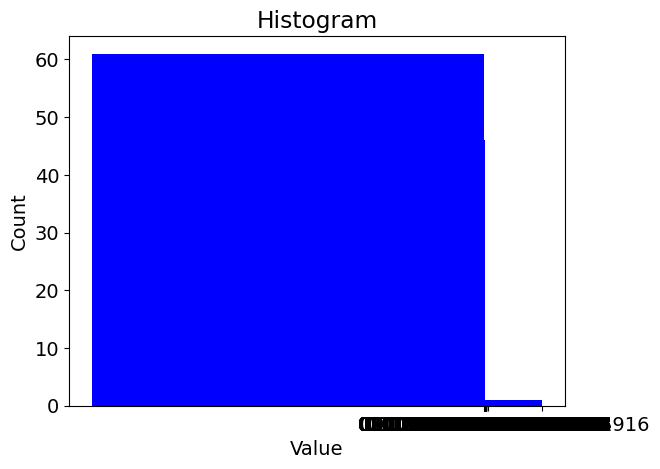


NW 22 PAGERANK
The mean network pagerank is 0.002293577981651371, with stdev 0.005464142594617916
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11486522972261974
The minimum node is http://local/local.owl#set_of_progs_shape_compare, with value 0.0014370819959748037
(0.11486522972261974, 0.013517004859554297, 0.005344318336029325, 0.004917011686373461, 0.00487080739382041, 0.004843606180039756, 0.004816248501968465, 0.004008939949135874, 0.0038616502423474467, 0.003796113643794257, 0.0037027204726479985, 0.0037007335508227163, 0.0036106693982832965, 0.003584501640674076, 0.003582641581261314, 0.0035278774316569927, 0.0035243858373955254, 0.003506914388935159, 0.0034952495145475185, 0.0034841123311426065, 0.0034519515740490414, 0.0034435058703572957, 0.003398255355647262, 0.003324145914126156, 0.003140059555507988, 0.003110176053084234, 0.0030597056340520372, 0.0030507850709142253, 0.003011185229806301, 0.003009848985125857, 0.0029719569877727026, 0.

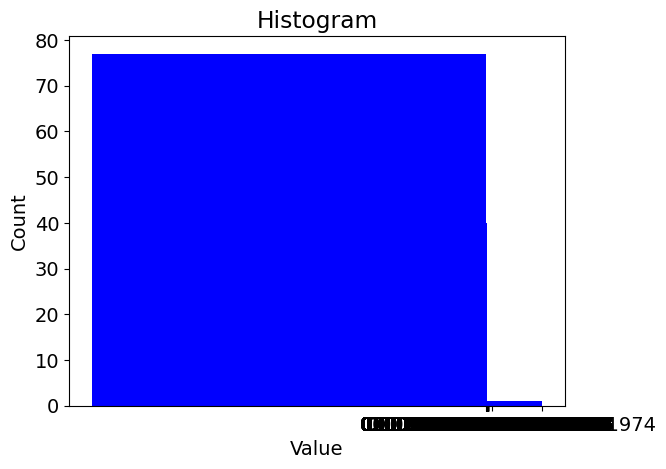


NW 23 PAGERANK
The mean network pagerank is 0.0024330900243309025, with stdev 0.005760728584296663
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11802599177052045
The minimum node is http://local/local.owl#s17, with value 0.0015544593303419244
(0.11802599177052045, 0.013052020144217115, 0.004475130469882505, 0.004455509053974642, 0.0038212674946352465, 0.003659649489061065, 0.0035887279184241287, 0.003495271737515166, 0.0034487392428332302, 0.003441235931121369, 0.003395124238574263, 0.0032875951884435975, 0.0032331598442384805, 0.0032074490227899126, 0.0032031044207904455, 0.0031804338299624237, 0.003177812059100868, 0.003109774482437641, 0.0030792330217477744, 0.0030730904952030384, 0.0030518160874977635, 0.0030492632314064764, 0.0030409382839806137, 0.0030164948295477107, 0.0029993457351107653, 0.0029981284486795003, 0.0029785588505488255, 0.0029767984264961406, 0.0029706491487331292, 0.002951309707688213, 0.002928677995667109, 0.002916851060077

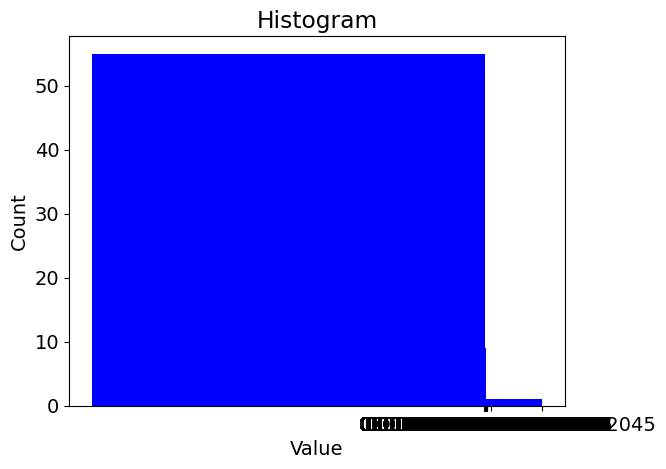


NW 0 BETWEENNESS CENTRALITY
The mean betwenness centrality is 4.940602077616393e-05, with stdev 0.0001154324792911184
The maximum node is http://local/local.owl#rdf_dataset, with value 0.001294713516935739
The minimum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.0
(0.001294713516935739, 0.0006457739791073125, 0.0005698005698005699, 0.0004590060145615702, 0.0004273504273504274, 0.0003418803418803419, 0.00033238366571699906, 0.0003100664767331434, 0.00029123140234251345, 0.0002659069325735993, 0.0002564102564102564, 0.00023979107312440648, 0.00023108578664134225, 0.0002310857866413422, 0.00022792022792022794, 0.00021842355175688511, 0.0002136752136752137, 0.00021209243431465655, 0.00018993352326685662, 0.00018281101614434948, 0.00017410572966128525, 0.00017331433998100666, 0.00017094017094017094, 0.0001646090534979424, 0.0001519468186134853, 0.00014561570117125675, 0.00014245014245014247, 0.00013770180436847106, 0.00013295346628679964, 0.0001234567901234568, 0.

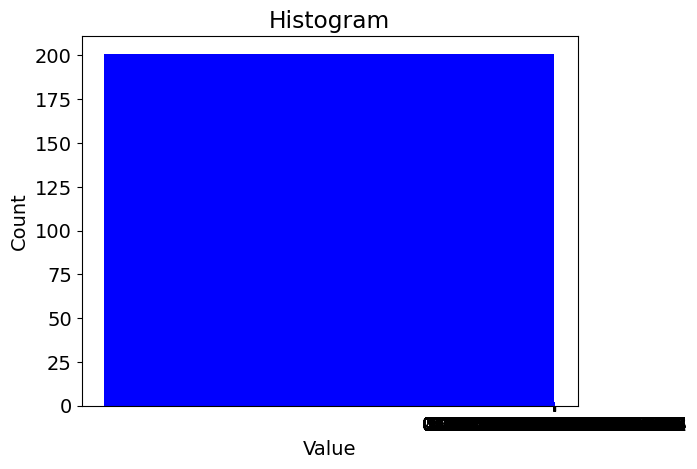


NW 1 BETWEENNESS CENTRALITY
The mean betwenness centrality is 2.574409746777338e-05, with stdev 5.303074918439765e-05
The maximum node is http://local/local.owl#rdf_graph, with value 0.0003740648379052369
The minimum node is functionality of the w3c recommendation, with value 0.0
(0.0003740648379052369, 0.00026392352452202824, 0.00026184538653366583, 0.00024729842061512884, 0.000243142144638404, 0.00021612635078969248, 0.00021612635078969243, 0.00020885286783042396, 0.00018703241895261845, 0.0001807980049875312, 0.00017975893599334996, 0.00017664172901080632, 0.00016209476309226933, 0.00015793848711554448, 0.00015586034912718207, 0.00015274314214463842, 0.0001517040731504572, 0.00015087281795511223, 0.00014962593516209478, 0.0001433915211970075, 0.00013923524522028264, 0.0001371571072319202, 0.00013092269326683292, 0.0001288445552784705, 0.00012468827930174565, 0.00012053200332502078, 0.00010286783042394016, 0.00010182876142975895, 9.975062344139652e-05, 9.351620947630923e-05, 8.93599

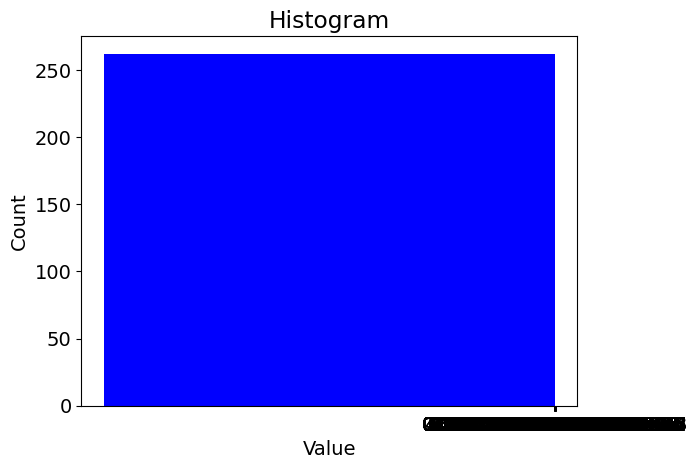


NW 2 BETWEENNESS CENTRALITY
The mean betwenness centrality is 6.198786218622332e-05, with stdev 0.00019916280497107424
The maximum node is http://local/local.owl#largest_open_collaborative_knowledge_base, with value 0.002488123912752576
The minimum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.0
(0.002488123912752576, 0.0016392345778134618, 0.0013948362252256272, 0.0012507991733202491, 0.0008772321096688822, 0.0008089306689266545, 0.0006950949343562752, 0.0005742896650162808, 0.0005018065034122842, 0.0004869381625704388, 0.00047764544954428527, 0.00046835273651813197, 0.00045906002349197856, 0.0004033037453350581, 0.0003549816375990604, 0.0003345376689415228, 0.00032338641331013877, 0.00031966932809967733, 0.00031409370028398536, 0.0003066595298630626, 0.0002973668168369092, 0.0002815692046924484, 0.00028017529773852537, 0.0002704179490610643, 0.0002606606003836032, 0.0002453276238904501, 0.00023789345346952734, 0.00021837875611460517, 0.00021466167090414381, 

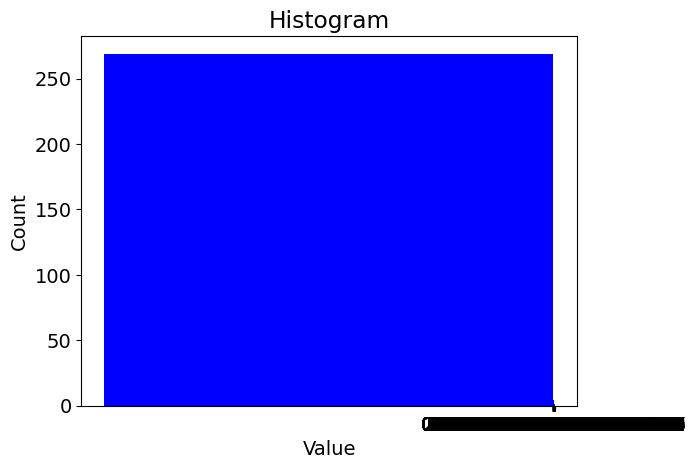


NW 3 BETWEENNESS CENTRALITY
The mean betwenness centrality is 3.281145319628704e-05, with stdev 7.563427121165406e-05
The maximum node is http://local/local.owl#percent_point_f1score, with value 0.0007647385984427142
The minimum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.0
(0.0007647385984427142, 0.0006025213199851687, 0.00045884315906562846, 0.00030898529230008654, 0.0003012606599925844, 0.00029817080706958347, 0.00029662588060808305, 0.0002935360276850822, 0.0002904461747620813, 0.00027808676307007786, 0.00025723025583982204, 0.00025491286614757135, 0.0002410085279940675, 0.0002317389692250649, 0.0002193795575330614, 0.00021165492522555926, 0.00020856507230255838, 0.0001921116054875788, 0.0001807563959955506, 0.0001672382894574218, 0.0001668520578420467, 0.00015294771968854282, 0.00014831294030404152, 0.00013981584476578914, 0.00013904338153503893, 0.0001313187492275368, 0.00012745643307378568, 0.00012668396984303546, 0.00012050426399703374, 0.00011586948

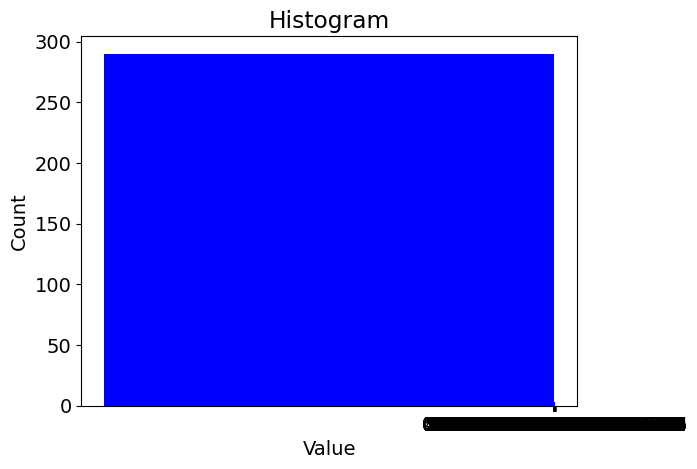


NW 4 BETWEENNESS CENTRALITY
The mean betwenness centrality is 4.4321489328392237e-05, with stdev 9.40281346859314e-05
The maximum node is http://local/local.owl#richer_counterpart_hyperrelational_knowledge_graph, with value 0.0007544129495349008
The minimum node is knowledge graph, with value 0.0
(0.0007544129495349008, 0.0005566542151908006, 0.0005302863839449205, 0.00047852730779560044, 0.0004248150589614004, 0.0004101662638248004, 0.0003955174686882004, 0.0003662198784150004, 0.0003588954808467004, 0.00029297590273200027, 0.00028748260455577527, 0.0002856515051637003, 0.00026367831245880025, 0.00025635391489050024, 0.00025330208257037524, 0.00024109475328987524, 0.00022705632461730022, 0.00021973192704900023, 0.00020508313191240022, 0.0001995898337361752, 0.0001977587343441002, 0.00019043433677580019, 0.00018494103859957519, 0.0001831099392075002, 0.00018188920627945017, 0.00017822700749530018, 0.00017578554163920018, 0.00017090260992700017, 0.00017029224346297518, 0.00016846114407

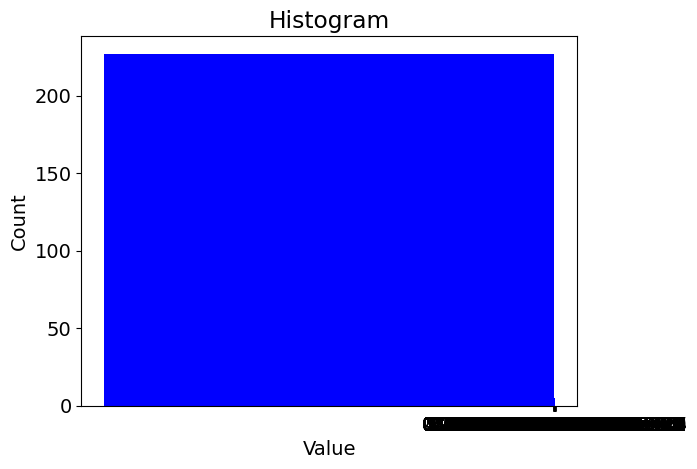


NW 5 BETWEENNESS CENTRALITY
The mean betwenness centrality is 3.399461545142119e-05, with stdev 8.287052074497574e-05
The maximum node is http://local/local.owl#knowledge_graph, with value 0.0007758728179551123
The minimum node is knowledge graph, with value 0.0
(0.0007758728179551123, 0.0006234413965087283, 0.0004488778054862843, 0.00041147132169576064, 0.0003927680798004988, 0.00035224438902743145, 0.0003428927680798005, 0.00034081463009143806, 0.00033915211970074813, 0.00033270989193682457, 0.0002493765586034913, 0.00022724438902743145, 0.00020729426433915214, 0.00020573566084788032, 0.0001963840399002494, 0.0001945137157107232, 0.0001807980049875312, 0.0001745635910224439, 0.00016832917705735662, 0.00016209476309226933, 0.00015586034912718207, 0.0001433915211970075, 0.0001371571072319202, 0.0001321695760598504, 0.00011970074812967581, 0.00011502493765586035, 0.0001142975893599335, 0.00011221945137157108, 0.00010910224438902743, 0.00010806317539484621, 0.0001059850374064838, 9.9750

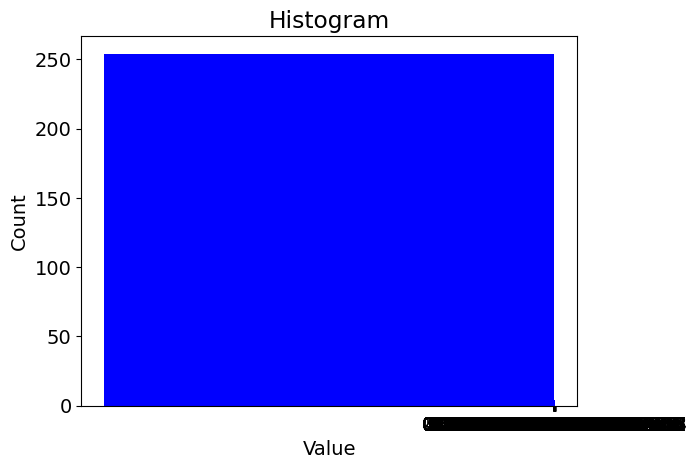


NW 6 BETWEENNESS CENTRALITY
The mean betwenness centrality is 1.901242312095569e-05, with stdev 4.8877726277117006e-05
The maximum node is http://local/local.owl#stateoftheart_scene_graph_reason_model, with value 0.0006915063540668365
The minimum node is knowledge graph, with value 0.0
(0.0006915063540668365, 0.00037399780276290876, 0.00033698760353116256, 0.0003227029652311904, 0.0002686485953006136, 0.000229852816281371, 0.00021297097101776748, 0.00020453004838596572, 0.00019738772923597964, 0.0001973877292359796, 0.00019543982401325617, 0.00019543982401325614, 0.00019284261704962484, 0.0001850509961587309, 0.00017579844635079436, 0.00017336356482239, 0.0001662212456724039, 0.0001499887021497082, 0.00014804079692698472, 0.00014414498648153775, 0.00013505476210882818, 0.00012661383947702642, 0.00012271802903157943, 0.00012077012380885596, 0.00011687431336340899, 0.00010973199421342288, 0.00010908269247251505, 0.0001077840889906994, 0.00010388827854525243, 0.00010129107158162113, 9.93

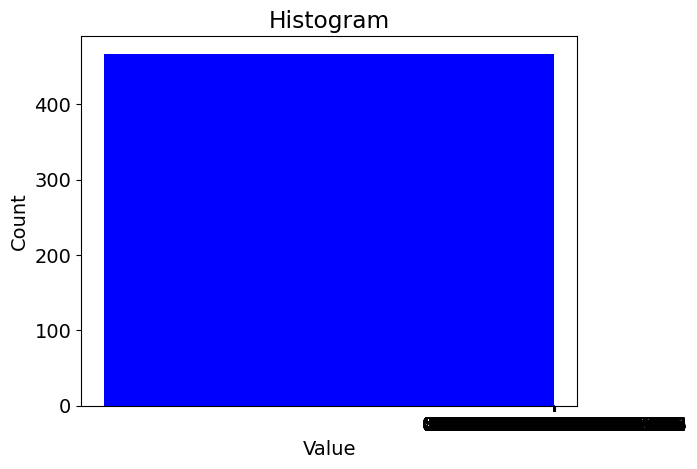


NW 7 BETWEENNESS CENTRALITY
The mean betwenness centrality is 9.314205994444014e-05, with stdev 0.00021445222657925244
The maximum node is http://local/local.owl#multiple_knowledge_base_relation_knowledge_base, with value 0.0015085469315705101
The minimum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.0
(0.0015085469315705101, 0.0012643774779697108, 0.0011838215721710868, 0.0011418924733765233, 0.0010297146219476316, 0.0009672712862726731, 0.0008195687807338293, 0.000798554196612449, 0.0006829739839448577, 0.0006817731505664932, 0.0006664625249923448, 0.0006315883222956732, 0.0005919107860855434, 0.0005392742563338957, 0.000525364603034506, 0.0005166085263172641, 0.0005043500189131257, 0.00048333543479174546, 0.00045531598929657183, 0.00045181355860967514, 0.000441306266548985, 0.00043260022455584175, 0.00042029168242760476, 0.00039687543154949534, 0.00037476008349794757, 0.00033973577662898055, 0.0003257260538813937, 0.00031521876182070356, 0.00030821390044691

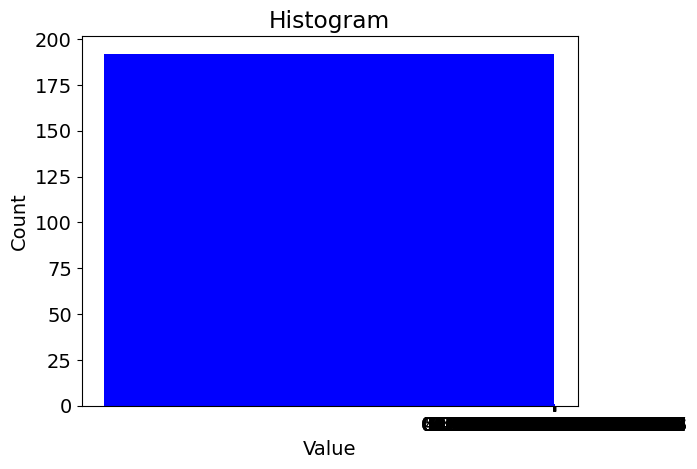


NW 8 BETWEENNESS CENTRALITY
The mean betwenness centrality is 3.132128659733353e-05, with stdev 7.380451505324012e-05
The maximum node is http://local/local.owl#zeroshot_visual_question, with value 0.0008211162233326188
The minimum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.0
(0.0008211162233326188, 0.0004617490393970877, 0.0004548777739298691, 0.00038341661307079604, 0.0003628028166691403, 0.0003490602857347032, 0.0003298207424264912, 0.0003215752238658289, 0.00031332970530516664, 0.00030783269293139175, 0.00030096142746417325, 0.00027485061868874264, 0.00026797935322152414, 0.00022675176041821272, 0.00021129141311697092, 0.00018140140833457016, 0.00017006382031365953, 0.0001649103712132456, 0.00016078761193291446, 0.00015666485265258332, 0.00014841933409192104, 0.00014567082790503362, 0.00014292232171814618, 0.00014154806862470249, 0.00013879956243781504, 0.00013708174607101042, 0.00012436990495665607, 0.0001236827784099342, 0.00012093427222304678, 0.0001

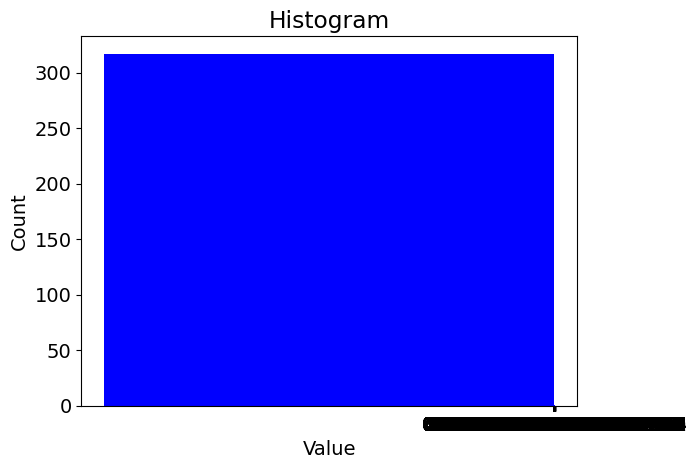


NW 9 BETWEENNESS CENTRALITY
The mean betwenness centrality is 1.889143366421891e-05, with stdev 3.865954693120913e-05
The maximum node is http://local/local.owl#more_active_editor, with value 0.00029662588060808305
The minimum node is knowledge graph, with value 0.0
(0.00029662588060808305, 0.00026396172113635967, 0.00023836008263149533, 0.000212758444126631, 0.00019686777195119802, 0.00019492557868531173, 0.0001589067217543302, 0.00013242226812860852, 0.00012712537740346418, 0.0001165315959531755, 0.00011229408337306002, 0.00010770344474460159, 0.0001072620371841729, 0.00010593781450288681, 0.00010240655401945725, 0.00010064092377774246, 9.88752935360277e-05, 9.79924784151703e-05, 9.534403305259813e-05, 9.110652047248265e-05, 8.475025160230945e-05, 8.07775835584512e-05, 8.051273902219398e-05, 7.94533608771651e-05, 7.680491551459293e-05, 7.415647015202076e-05, 7.062520966859121e-05, 6.559316347970406e-05, 6.356268870173209e-05, 6.003142821830253e-05, 5.959002065787383e-05, 5.932517612

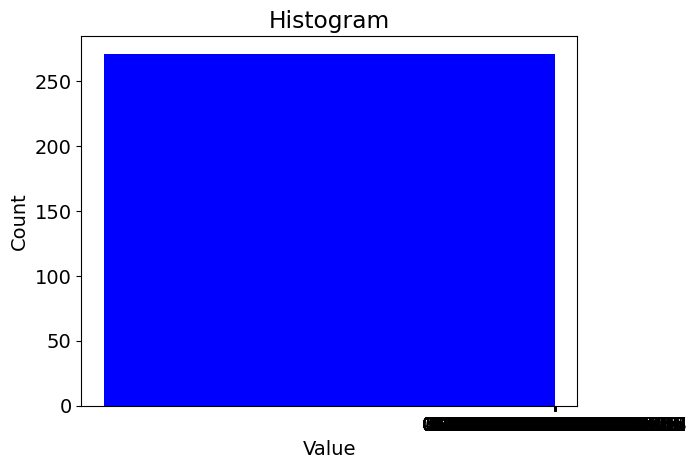


NW 10 BETWEENNESS CENTRALITY
The mean betwenness centrality is 4.603907042931433e-05, with stdev 0.00010074234882699438
The maximum node is http://local/local.owl#more_data_source, with value 0.0007251153592617007
The minimum node is http://local/local.owl#s13.1, with value 0.0
(0.0007251153592617007, 0.0006591957811470007, 0.0006445469860104007, 0.0005737444761835006, 0.0004760858419395005, 0.0004419053199541004, 0.00043946385409800046, 0.00037110281012720035, 0.00032227349300520034, 0.00029297590273200027, 0.00026367831245880025, 0.0002484191508581753, 0.00024414658561000026, 0.00024170511975390025, 0.00022949779047340023, 0.00022217339290510023, 0.0002124075294807002, 0.00020508313191240022, 0.0002002002002002002, 0.00018555140506360017, 0.0001831099392075002, 0.00017212334285505017, 0.0001709026099270002, 0.00017090260992700017, 0.00017029224346297518, 0.00016601967821480018, 0.00015625381479040016, 0.00015381234893430015, 0.00015137088307820015, 0.00014648795136600013, 0.00014282

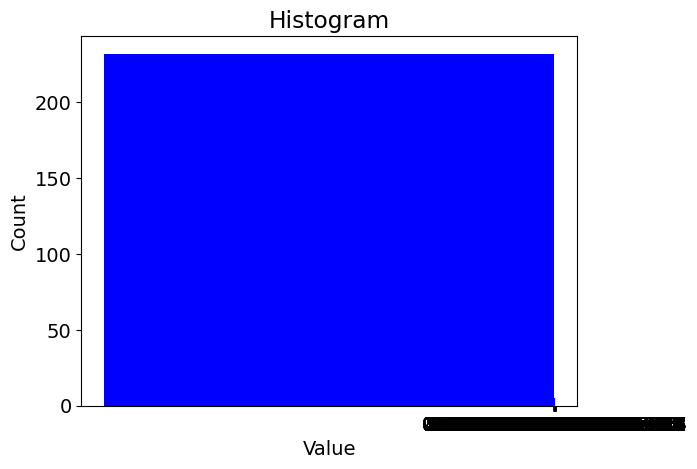


NW 11 BETWEENNESS CENTRALITY
The mean betwenness centrality is 5.361036094441549e-05, with stdev 0.00010626757676120804
The maximum node is http://local/local.owl#tractable_reasoner, with value 0.000829476268683953
The minimum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.0
(0.000829476268683953, 0.0004976857612103717, 0.000423032897028816, 0.0003805222382587634, 0.0003794853929229085, 0.0003649695582209393, 0.00036082217687751953, 0.00034838003284726025, 0.0003359378888170009, 0.00032847260239884533, 0.00031105360075648237, 0.0002986114567262231, 0.0002799482406808341, 0.00027787455000912424, 0.0002633587153071551, 0.0002612850246354452, 0.00024884288060518587, 0.00024054811791834635, 0.00023951127258249141, 0.00023017966455979696, 0.00022810597388808705, 0.0002239585925446673, 0.0001990743044841487, 0.00018870585112559928, 0.0001866321604538894, 0.00018041108843875977, 0.00017730055243119495, 0.00016174787239337082, 0.0001534531097065313, 0.00014930572836311

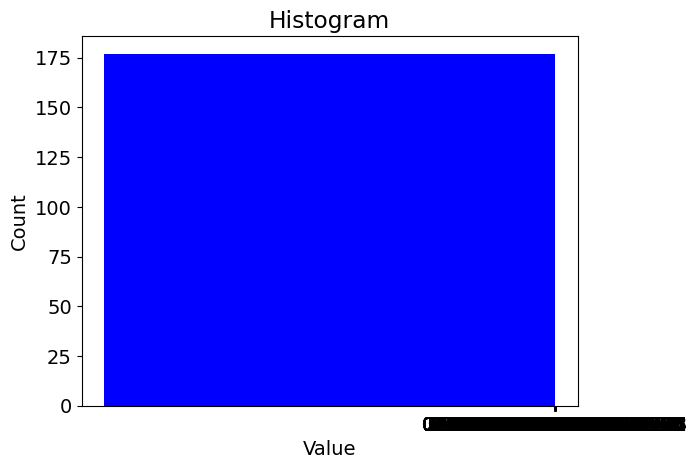


NW 12 BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.00011776359233986355, with stdev 0.00022857115062859635
The maximum node is http://local/local.owl#important_nod, with value 0.0012987012987012987
The minimum node is important, with value 0.0
(0.0012987012987012987, 0.0010714285714285715, 0.0009090909090909091, 0.0008766233766233766, 0.0008441558441558442, 0.0008225108225108225, 0.0006493506493506494, 0.000625, 0.0005844155844155844, 0.0005681818181818182, 0.0005573593073593073, 0.0005194805194805195, 0.0004951298701298701, 0.000487012987012987, 0.00045454545454545455, 0.0004301948051948052, 0.00040584415584415587, 0.0003896103896103896, 0.00037337662337662335, 0.00036796536796536797, 0.0003679653679653679, 0.00035714285714285714, 0.0003246753246753247, 0.0003084415584415584, 0.00030303030303030303, 0.0002922077922077922, 0.0002705627705627705, 0.00025974025974025974, 0.00022727272727272727, 0.0001948051948051948, 0.00017857142857142857, 0.0001731601731601732, 0.0001704

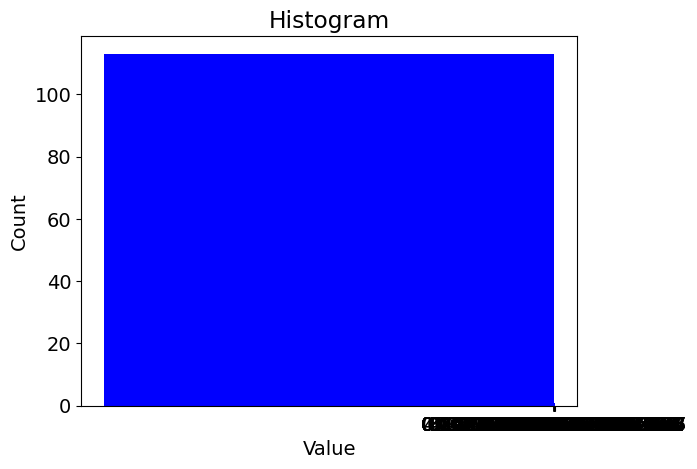


NW 13 BETWEENNESS CENTRALITY
The mean betwenness centrality is 6.250112412093744e-05, with stdev 0.0001549391388267367
The maximum node is http://local/local.owl#general_purpose_entity_search_service, with value 0.0014244860519074085
The minimum node is http://local/local.owl#do_not_presuppose, with value 0.0
(0.0014244860519074085, 0.000982032050936168, 0.0009793341606863432, 0.0006798683429558085, 0.00066907678195651, 0.0006474936599579129, 0.0006151189769600172, 0.0005557653914638753, 0.0005440745337146352, 0.0005125991474666811, 0.0005072033669670318, 0.000491016025468084, 0.000453245561970539, 0.0004145758017230526, 0.00035792010647673527, 0.00035072573247720283, 0.00034532995197755355, 0.00033993417147790427, 0.00032374682997895647, 0.0003039623014802425, 0.0003021637079803594, 0.00026439324448281445, 0.00025899746398316516, 0.0002401122322343927, 0.00022842137448515263, 0.0002266227809852695, 0.00022392489073544487, 0.00021942840698573713, 0.00021583121998597097, 0.000205039658

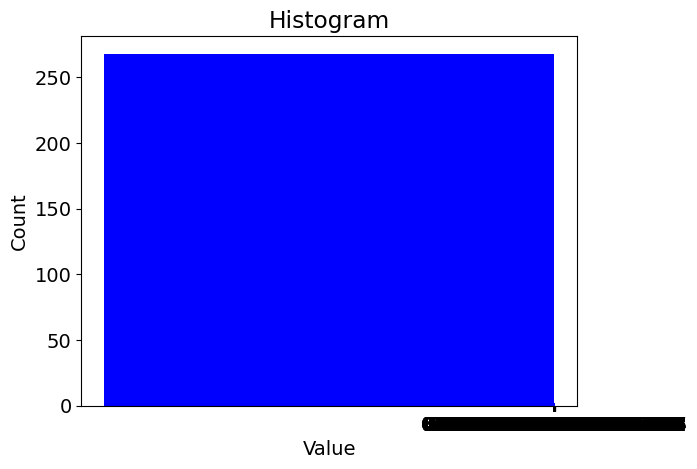


NW 14 BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.00011979146642940263, with stdev 0.0002558534622621557
The maximum node is http://local/local.owl#common_owl_axiom, with value 0.0022512008133370683
The minimum node is closest, with value 0.0
(0.0022512008133370683, 0.0016183747782515328, 0.0009959229404624818, 0.0009103358127664872, 0.0009025551647941241, 0.0008714325729046715, 0.000840309981015219, 0.0007521293039951034, 0.0007469422053468613, 0.0006846970215679563, 0.0006639486269749879, 0.0006613550776508668, 0.0006419034577199589, 0.0006354195844096563, 0.0005446453580654197, 0.0005187098648242093, 0.000505742118203604, 0.0004668388783417883, 0.0004590582303694252, 0.00043571628645233576, 0.0004097807932111253, 0.00040848401854906476, 0.0004045936945628832, 0.0003890323986181569, 0.00037865820132167274, 0.00037347110267343063, 0.0003708775533493096, 0.00035012915875634127, 0.0003423485107839781, 0.00032678721483925184, 0.0003164130175427676, 0.00031511624288070713,

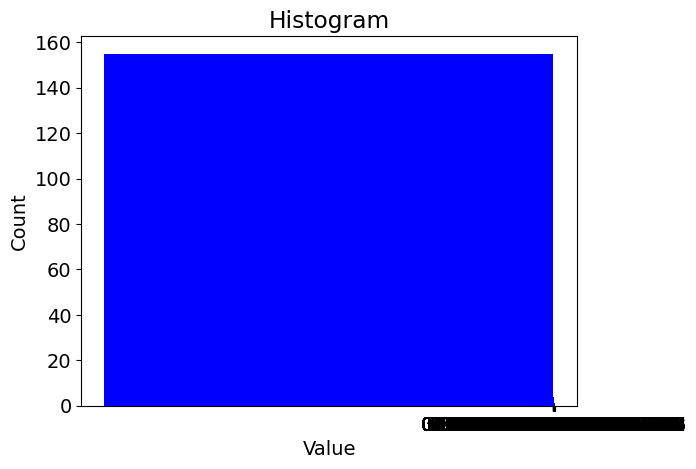


NW 15 BETWEENNESS CENTRALITY
The mean betwenness centrality is 5.28226018026873e-05, with stdev 0.00015018214141809903
The maximum node is http://local/local.owl#continuous_knowledge_graph_representation, with value 0.0018434266841910153
The minimum node is knowledge graph, with value 0.0
(0.0018434266841910153, 0.00088295757085566, 0.000754895022410946, 0.0006605331446095778, 0.0005055100596501871, 0.000498769925521518, 0.0004886597243285142, 0.00040440804772014964, 0.00038418764533414216, 0.000377447511205473, 0.00033363663936912346, 0.00030499106932227953, 0.00029235331783102487, 0.000272975432211101, 0.0002578101304215954, 0.00025612509688942807, 0.00025275502982509353, 0.0002426448286320898, 0.00023590469450342062, 0.00022916456037475147, 0.0002224244262460823, 0.00021231422505307856, 0.00020220402386007482, 0.00019546388973140565, 0.000194621372965322, 0.00018198362147406734, 0.00017642301081791526, 0.0001718734202810636, 0.00016176321908805986, 0.000156708118491558, 0.000155023

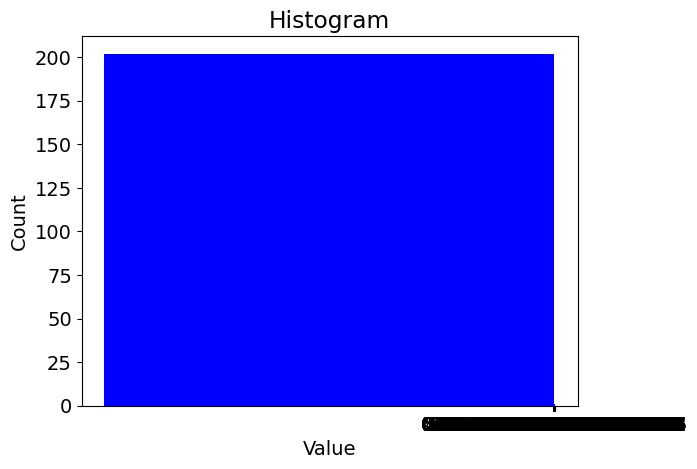


NW 16 BETWEENNESS CENTRALITY
The mean betwenness centrality is 6.349924429226866e-05, with stdev 0.00013726638622141602
The maximum node is http://local/local.owl#actual_background_dataset, with value 0.0012868883624345588
The minimum node is https://cso.kmi.open.ac.uk/topics/general_purpose, with value 0.0
(0.0012868883624345588, 0.0005264543300868649, 0.00048258313591295957, 0.00046795940452165776, 0.00044602380743470507, 0.00043871194173905414, 0.00042896278747818625, 0.0003997153246955826, 0.0003984966804129742, 0.0003948407475651487, 0.00038021701617384695, 0.00037046786191297906, 0.0003692492176303706, 0.0003582814190868942, 0.00035096955339124333, 0.00032537802345646515, 0.0003217220906086397, 0.0002924746278260361, 0.0002778508964347343, 0.00026322716504343247, 0.00023397970226082888, 0.00022666783656517797, 0.00021935597086952707, 0.00020473223947822526, 0.0001949830852173574, 0.00019376444093474892, 0.00019010850808692348, 0.00017548477669562167, 0.0001559864681738859, 0.000

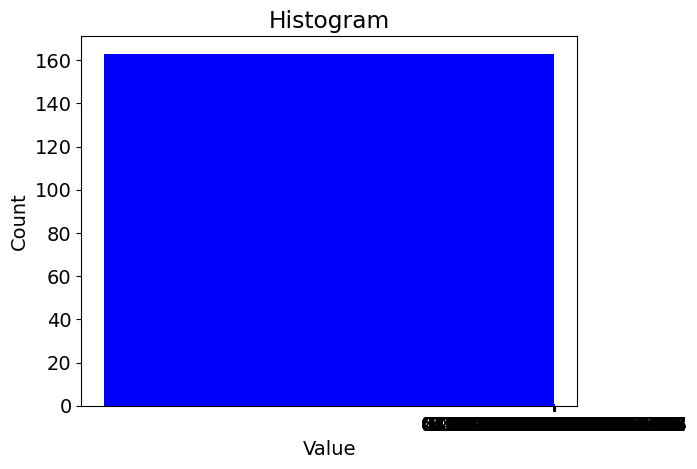


NW 17 BETWEENNESS CENTRALITY
The mean betwenness centrality is 3.1849642020103286e-05, with stdev 8.202461158153508e-05
The maximum node is http://local/local.owl#complex_semantic_description, with value 0.0009598966265171443
The minimum node is http://local/local.owl#s21, with value 0.0
(0.0009598966265171443, 0.0006191640900210745, 0.0006030119833248728, 0.0005076376390234897, 0.0003876505607088467, 0.0003530389035026997, 0.00030919747104158013, 0.0002924300459950467, 0.00025151137569800173, 0.00022843693756057038, 0.000221514606119341, 0.0002099773870506253, 0.00020766994323688216, 0.00019844016798190964, 0.0001961327241681665, 0.00019382528035442336, 0.00015921362314827632, 0.00015805990124140477, 0.00015459873552079007, 0.0001538295875828757, 0.00015229129170704693, 0.0001499838478933038, 0.00014883012598643222, 0.00013998492470041686, 0.0001384466288245881, 0.000136139185010845, 0.00012921685356961557, 0.00012575568784900087, 0.00012229452212838616, 0.00011652591259402833, 0.000

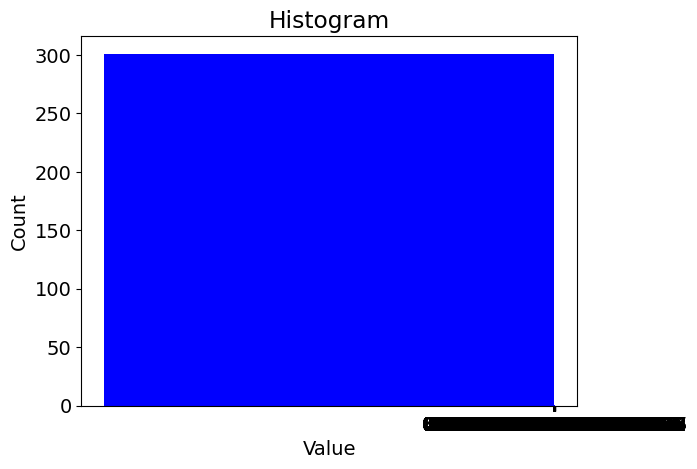


NW 18 BETWEENNESS CENTRALITY
The mean betwenness centrality is 4.01402693666304e-05, with stdev 8.162989513931878e-05
The maximum node is http://local/local.owl#knowledge_base, with value 0.0006672124437167418
The minimum node is http://local/local.owl#s7, with value 0.0
(0.0006672124437167418, 0.000540319279574294, 0.00045231273024969303, 0.0003765861645517806, 0.0003602128530495293, 0.0003179151316687133, 0.0002742529676627098, 0.000270159639787147, 0.00025651521353527087, 0.00022922636103151864, 0.00021489971346704874, 0.00021285304952926731, 0.0002121708282166735, 0.00020875972165370447, 0.00020671305771592305, 0.00020466639377814165, 0.00019647973802701597, 0.0001882930822758903, 0.00018010642652476464, 0.00016919088552326374, 0.00016373311502251332, 0.00015827534452176286, 0.00015554645927138766, 0.00015309046254604995, 0.00015281757402101241, 0.0001489971346704871, 0.00014735980352026197, 0.00014463091826988675, 0.00013371537726838587, 0.00013098649201801065, 0.0001282576067676

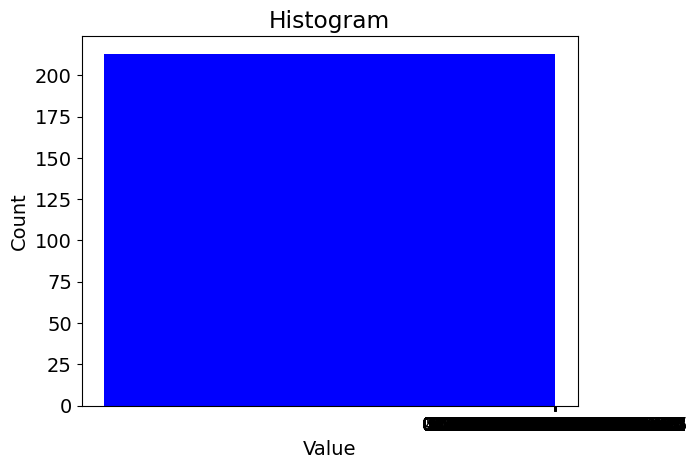


NW 19 BETWEENNESS CENTRALITY
The mean betwenness centrality is 3.011204446574567e-05, with stdev 6.743531184033919e-05
The maximum node is http://local/local.owl#internet_host_markup, with value 0.0005182540596568007
The minimum node is http://local/local.owl#s7.1, with value 0.0
(0.0005182540596568007, 0.0004318783830473339, 0.00042228108564628205, 0.00040308649084417833, 0.000385891333000627, 0.0003710954995073388, 0.00031831036380155353, 0.0002903182463818189, 0.00028631937246471396, 0.0002703238767962942, 0.0002639256785289263, 0.00021593919152366694, 0.00021114054282314102, 0.00020314279498893112, 0.00018874684888735334, 0.0001743509027857755, 0.00017395101539406505, 0.00017275135321893355, 0.00016795270451840764, 0.00015355675841682983, 0.00015115743406656686, 0.00015035765928314587, 0.0001499577718914354, 0.000140760361882094, 0.00013916081231525203, 0.00012316531664683227, 0.00012156576707999027, 0.00011676711837946434, 0.00011516756881262237, 0.00011036892011209644, 0.0001071

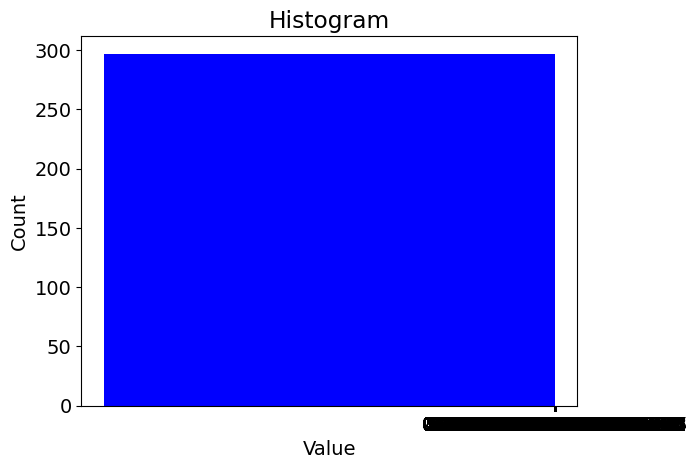


NW 20 BETWEENNESS CENTRALITY
The mean betwenness centrality is 2.4586783414231763e-05, with stdev 6.943943253004218e-05
The maximum node is http://local/local.owl#neural_network, with value 0.001068176771041528
The minimum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.0
(0.001068176771041528, 0.0003997335109926716, 0.0003419942260715079, 0.0002738914797542379, 0.00027093049078392187, 0.00023391812865497077, 0.00020874972240728405, 0.00020430823895180991, 0.0001998667554963358, 0.00018580205788733438, 0.00018136057443186024, 0.00017765933821896514, 0.00015249093197127844, 0.0001510104374861204, 0.0001474572507217411, 0.00014656895403064625, 0.00014212747057517212, 0.00013857428381079282, 0.0001347249981493819, 0.00013324450366422385, 0.00012880302020874975, 0.0001273225257235917, 0.00012288104226811756, 0.00011992005329780148, 0.0001169590643274854, 0.00011658894070619589, 0.00010215411947590496, 9.99333777481679e-05, 9.948922940262048e-05, 9.919313050558889e-0

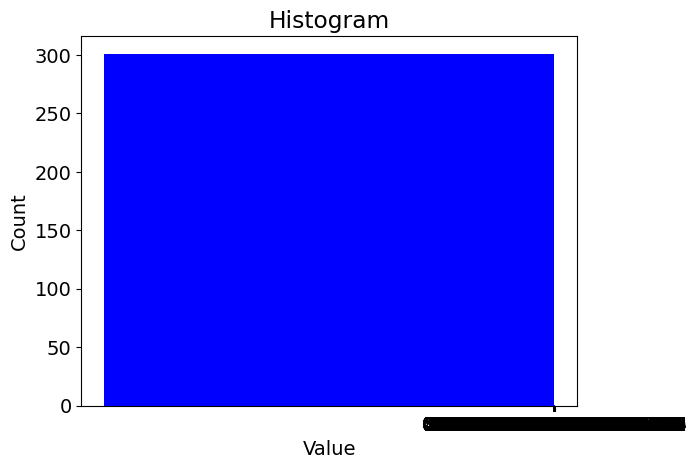


NW 21 BETWEENNESS CENTRALITY
The mean betwenness centrality is 2.582387141057666e-05, with stdev 6.298781481284062e-05
The maximum node is http://local/local.owl#answer_conjunctive_query, with value 0.0005268143165781548
The minimum node is http://local/local.owl#typically_constitute_by_conjunctive_query, with value 0.0
(0.0005268143165781548, 0.0004789221059801407, 0.0004469939655814645, 0.0003760425424732956, 0.0002962221914766055, 0.0002780408893051372, 0.00027671055012185904, 0.00023059212510154921, 0.00021285426932450696, 0.00019156884239205626, 0.00018199040027245346, 0.00017560477219271824, 0.00017028341545960557, 0.00016141448757108441, 0.00014012906063863375, 0.0001396856142442077, 0.00013835527506092952, 0.00013480770390552108, 0.00013303391832781685, 0.00012372154404486968, 0.00012061741928388726, 0.000118400187311757, 0.00011352227697307038, 0.00011307883057864432, 0.00011174849139536616, 0.00010642713466225348, 0.00010287956350684503, 9.578442119602813e-05, 9.223685004061

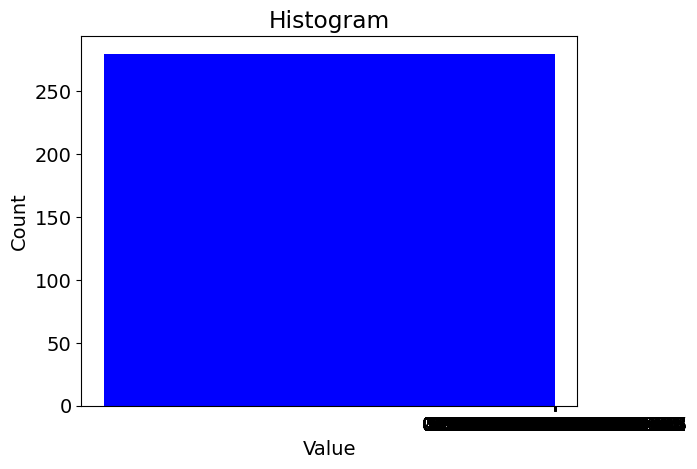


NW 22 BETWEENNESS CENTRALITY
The mean betwenness centrality is 3.435689672180778e-05, with stdev 8.282829429204727e-05
The maximum node is http://local/local.owl#property_graph, with value 0.0007662835249042147
The minimum node is knowledge graph, with value 0.0
(0.0007662835249042147, 0.0005826579797658775, 0.0005032046188887123, 0.00045023571163726897, 0.00036725109027667424, 0.0003654854600349595, 0.0003495947878595265, 0.00031075092254180135, 0.0003107509225418013, 0.00028603209915779436, 0.0002595476455320727, 0.0002457757296466974, 0.00024365697335663967, 0.000233063191906351, 0.00022776630118120664, 0.0002224694104560623, 0.00021893814997263277, 0.00021717251973091796, 0.00021611314158588907, 0.0001977505870720554, 0.0001822130409449653, 0.0001716192594946766, 0.00016773487296290412, 0.00016596924272118933, 0.00016420361247947455, 0.00016243798223775977, 0.00016102547804438795, 0.0001589067217543302, 0.00015360983102918587, 0.00014654731006232677, 0.00014478167982061196, 0.0001

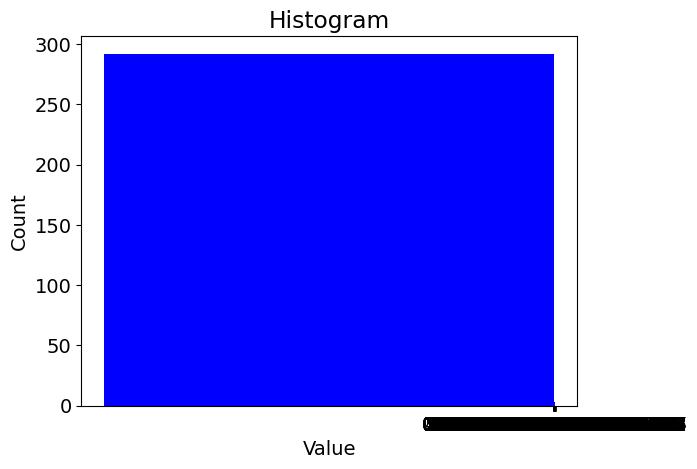


NW 23 BETWEENNESS CENTRALITY
The mean betwenness centrality is 2.5739768043192896e-05, with stdev 5.311251427313604e-05
The maximum node is http://local/local.owl#novel_iterative_approach_reasonkge, with value 0.00034488242192935373
The minimum node is http://local/local.owl#s17, with value 0.0
(0.00034488242192935373, 0.00032798616494722407, 0.00031009601049555727, 0.0002683523167750015, 0.00023644820800286246, 0.0002200488997555012, 0.00020225813505078818, 0.00019082831415111217, 0.00018387103186435287, 0.00017890154451666765, 0.00017492595463851948, 0.00016995646729083428, 0.0001490846204305564, 0.00014312123561333414, 0.000140139543204723, 0.00012721887610074145, 0.00012523108116166737, 0.00012125549128351919, 0.00010734092671000059, 0.00010336533683185242, 0.00010137754189277835, 9.541415707555609e-05, 8.945077225833382e-05, 8.64690798497227e-05, 8.348738744111158e-05, 8.050569503250044e-05, 7.95117975629634e-05, 7.901484882819488e-05, 7.752400262388932e-05, 7.156061780666707e-05

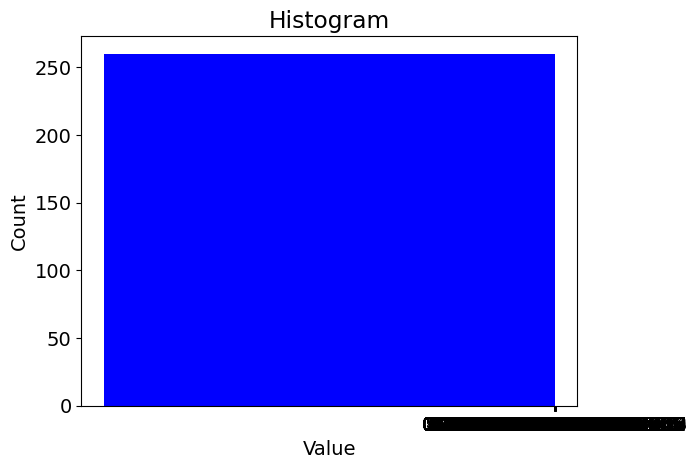

In [14]:
for i in TKG:
    # Degree centrality -- mean and stdev
    dc = nx.degree_centrality(TKG[i])
    degrees = []
    for k,v in dc.items():
        degrees.append(v)

    print(f"NW {i} DEGREE CENTRALITY")
    print("=================")
    print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
    print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
    histogram(dc)
    print()

for i in TKG:
    # PageRank -- mean and stdev
    pc = nx.pagerank(TKG[i])
    degrees = []
    for k,v in pc.items():
        degrees.append(v)

    print(f"NW {i} PAGERANK")
    print("======================")
    print("The mean network pagerank is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(pc, key=pc.get), max(pc.values())))
    print("The minimum node is {}, with value {}".format(min(pc, key=pc.get), min(pc.values())))
    histogram(pc)
    print()

for i in TKG:
    # Betweenness centrality -- mean and stdev
    bc = nx.betweenness_centrality(TKG[i])
    degrees = []
    for k,v in bc.items():
        degrees.append(v)

    print(f"NW {i} BETWEENNESS CENTRALITY")
    print("======================")
    print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
    print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
    histogram(bc)
    print()